In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from itertools import combinations
import seaborn as sns

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
# K-means
P_bus_shed_set = pd.read_csv('P_bus_shed_set_noMER.csv')
# P_system_shed_set = pd.read_csv('P_system_shed_set.csv')
nB = P_bus_shed_set.shape[1]
n_scenario = len(P_bus_shed_set)
wcss = []

k_range = list(range(5, 55, 5))
for k in k_range:
      # Create random centers
      unique_random_nums = random.sample(range(0, n_scenario), k)
      # Apply k-means clustering
      kmeans = KMeans(n_clusters = k, init='k-means++', random_state=42)
      kmeans.fit(P_bus_shed_set)
      y_kmeans = kmeans.predict(P_bus_shed_set)
      centers = kmeans.cluster_centers_
      wcss.append(kmeans.inertia_)

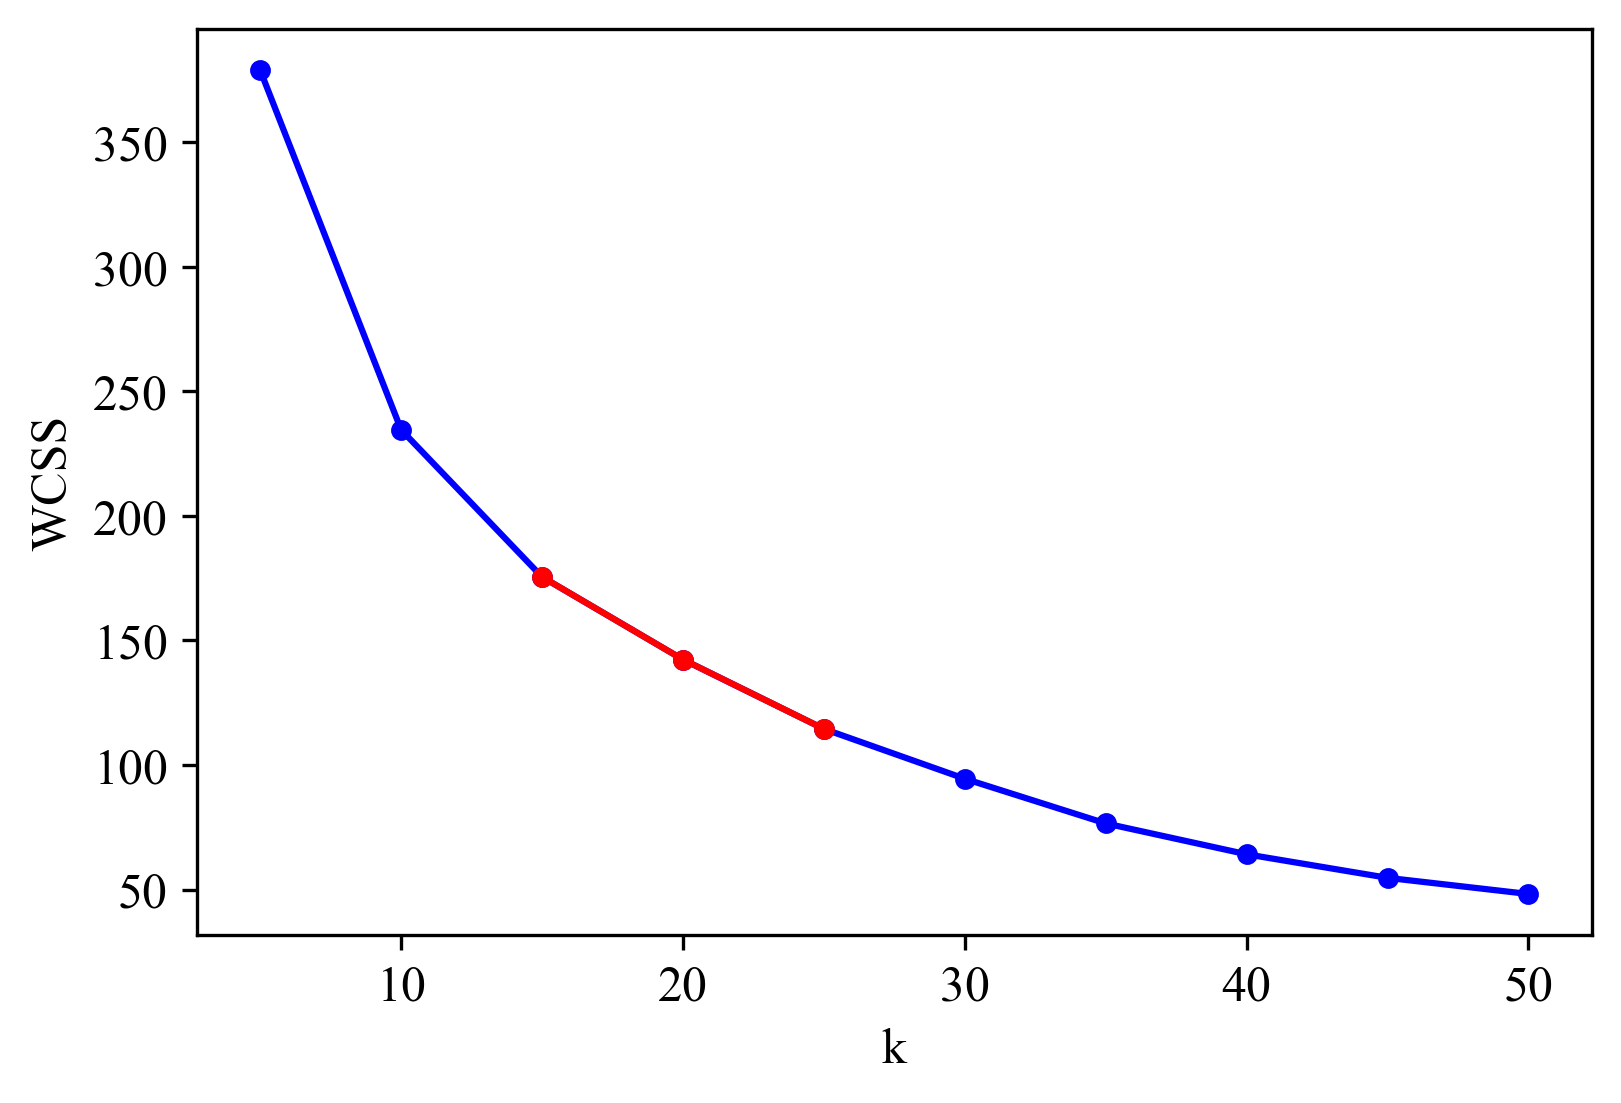

In [3]:
# plot elbow curve
plt.rcParams['font.size'] = 16
plt.plot(k_range, wcss, '-o', markersize=4, c='blue')
plt.plot(k_range[2:5], wcss[2:5], '-o', markersize=4, c='red')
plt.xlabel('k', fontsize = 12)
plt.ylabel('WCSS', fontsize = 12)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

Plot the original nodal load shedding curve and clustered load shedding curve

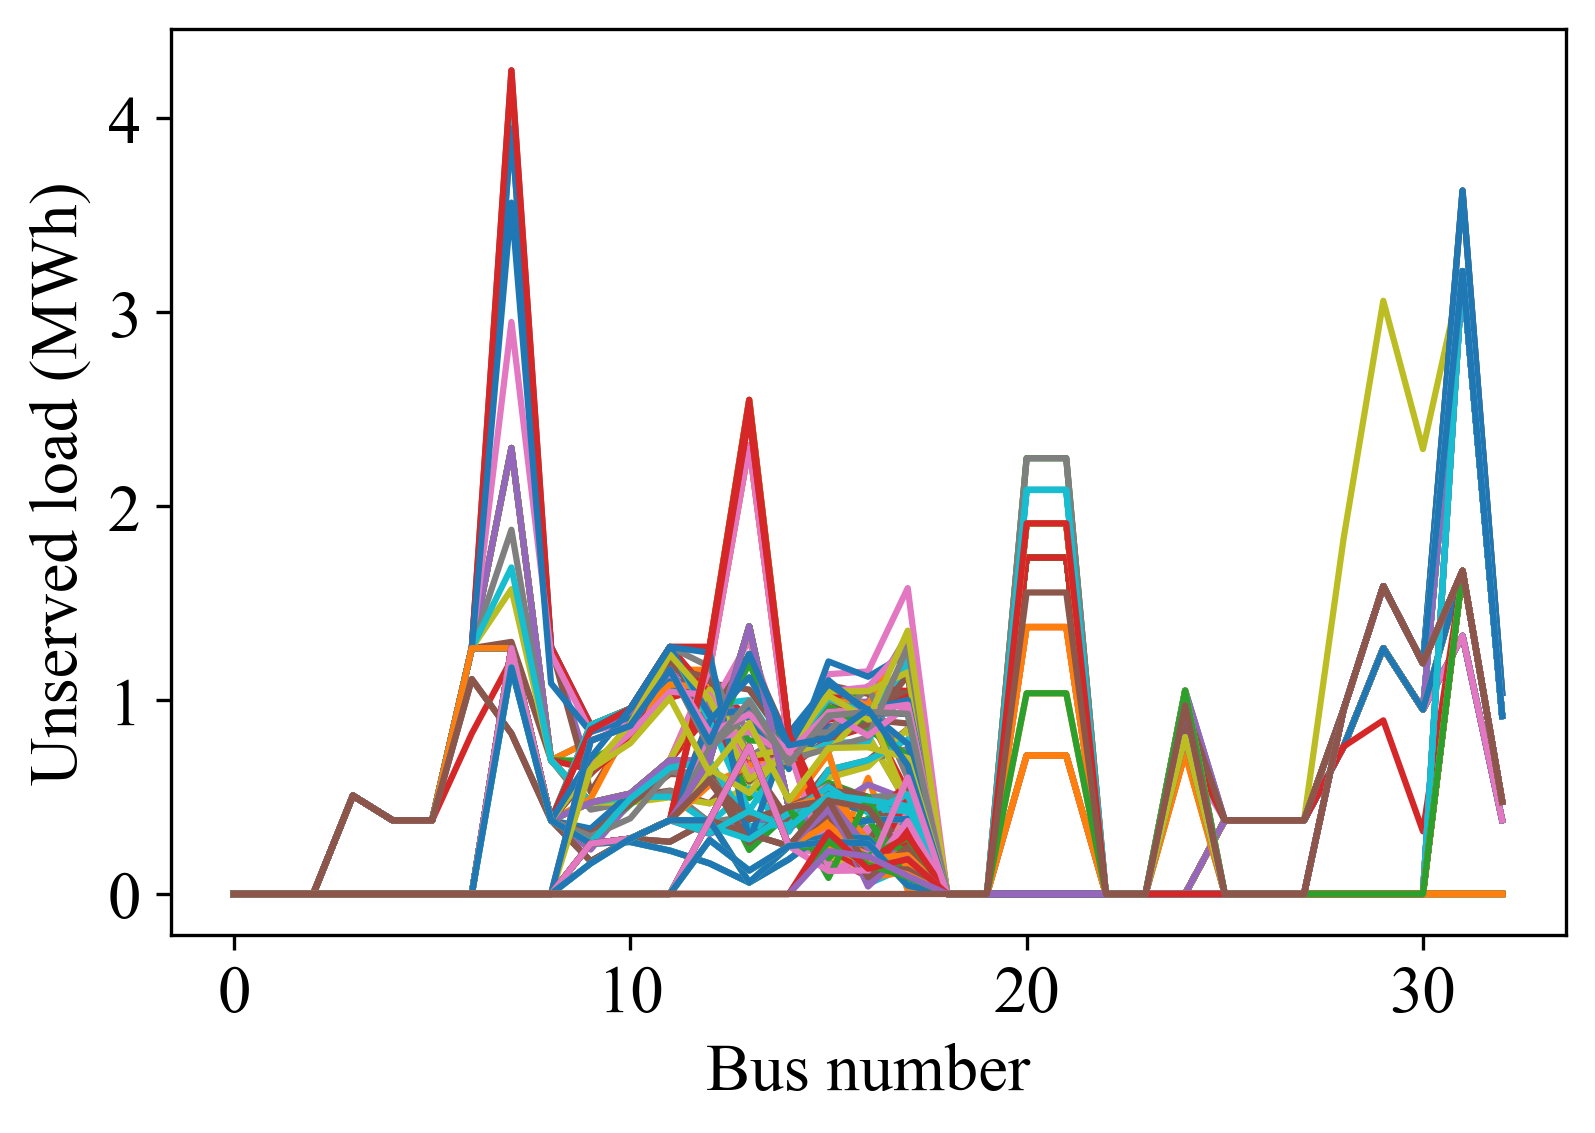

In [4]:
# Plot nodal unserved load at different node: original scenarios
P_bus_shed_set_np = P_bus_shed_set.values
node = range(nB)
for i in range(n_scenario):
      plt.plot(node, P_bus_shed_set_np[i])

plt.xlabel('Bus number')
plt.ylabel('Unserved load (MWh)')
plt.show()



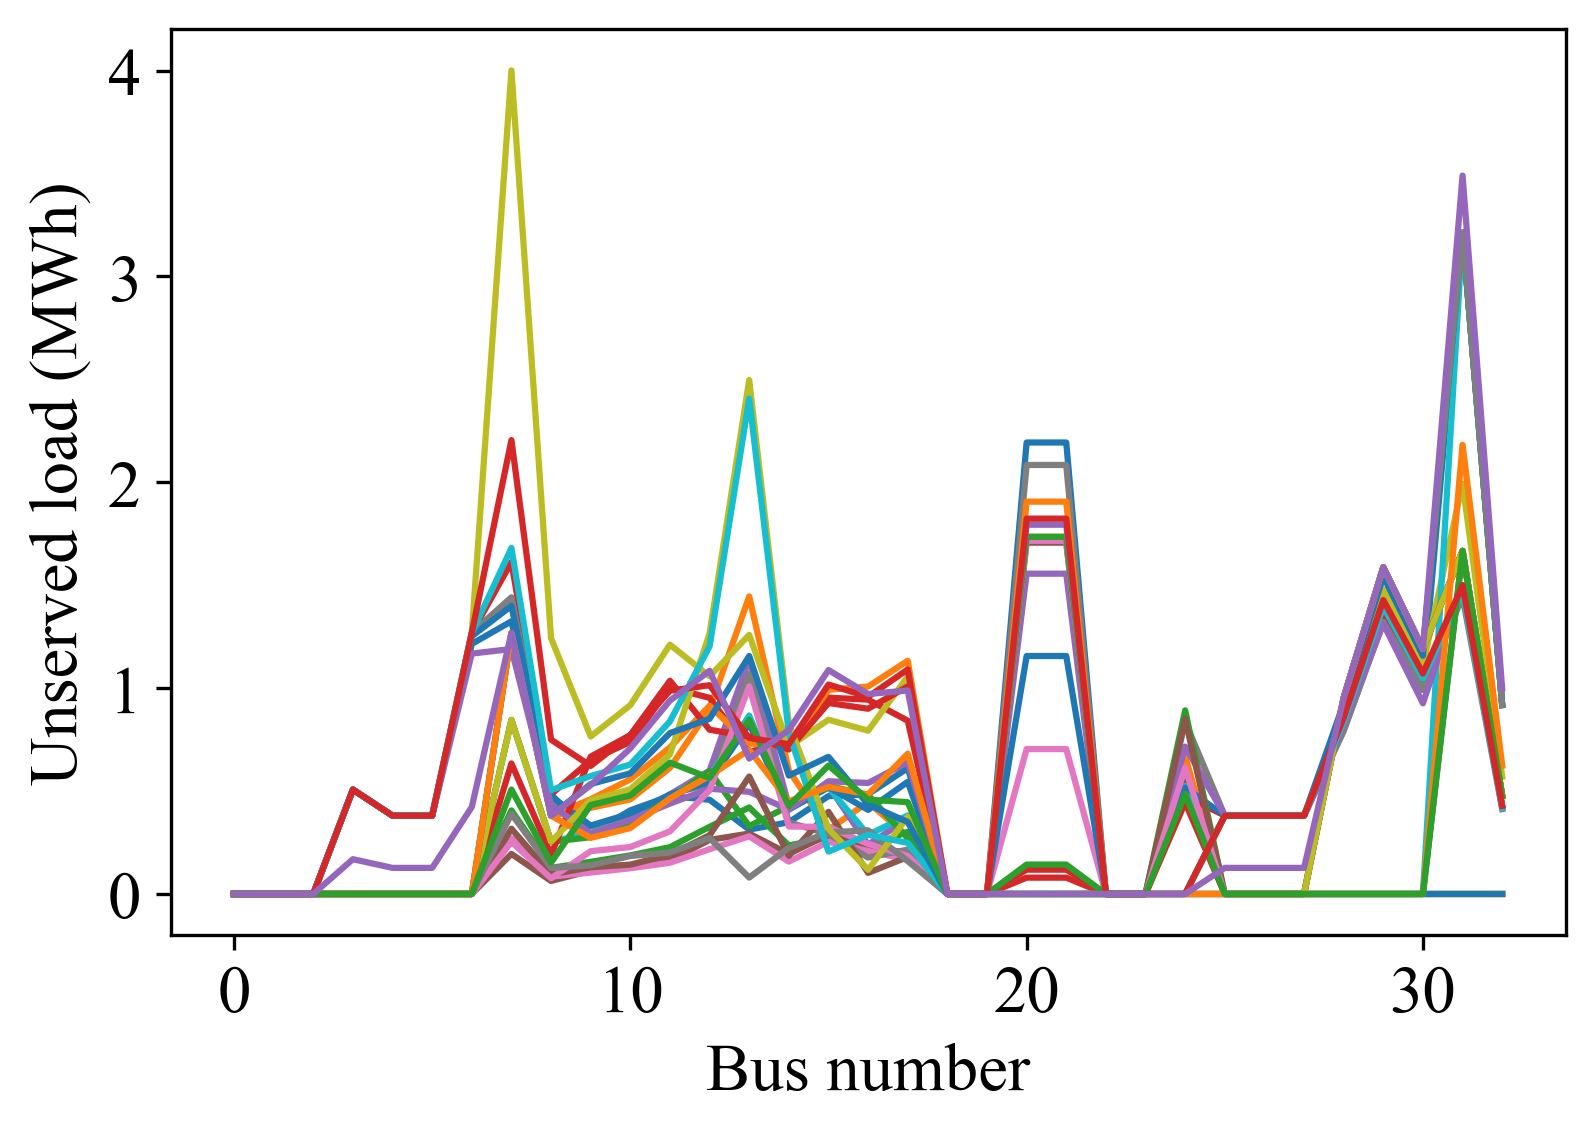

In [5]:
# Plot nodal unserved load at different node: clustered scenarios

k = 25
# Create random centers
unique_random_nums = random.sample(range(0, n_scenario), k)
# Apply k-means clustering
kmeans = KMeans(n_clusters = k, init='k-means++', random_state=42)
kmeans.fit(P_bus_shed_set)
y_kmeans = kmeans.predict(P_bus_shed_set)
centers = kmeans.cluster_centers_

P_bus_shed_set_np = P_bus_shed_set.values
node = range(nB)
for i in range(k):
      plt.plot(node, centers[i])

plt.xlabel('Bus number')
plt.ylabel('Unserved load (MWh)')
plt.show()



In [6]:
# calculate EENS: original scenarios
print(sum(sum(P_bus_shed_set_np))/n_scenario)

# calculate EENS: after clustering
EENS_k15 = 0
for i in range(n_scenario):
      j = y_kmeans[i] 
      EENS_k15 = EENS_k15 + sum(P_bus_shed_set_np[j,:])

print(EENS_k15/n_scenario)

14.62969068336885
20.94348984781458


EENS range and probability

In [7]:
# Original scenarios
EENS_original = np.sum(P_bus_shed_set_np, axis=1)
EENS_original_prob = np.zeros((n_scenario,2))
for i in range(n_scenario):
      EENS_original_prob[i,0] = EENS_original[i]
      EENS_original_prob[i,1] = 1/n_scenario
# Cluster
EENS_cluster = np.sum(centers, axis=1)
unique, counts = np.unique(y_kmeans, return_counts=True)
EENS_cluster_prob = np.zeros((k,2))
for i in range(k):
      EENS_cluster_prob[i,0] = EENS_cluster[i]
      EENS_cluster_prob[i,1] = counts[i]/n_scenario


In [8]:
sorted_original = EENS_original_prob[EENS_original_prob[:, 0].argsort()[::-1]]
sorted_cluster = EENS_cluster_prob[EENS_cluster_prob[:, 0].argsort()[::-1]]


In [9]:
# Calculate distribution at different range
range1 = list(range(0,35,5))
# range1 = list(range(4,32,4))

prob_original = np.zeros(len(range1) - 1)
count_original = np.zeros(len(range1) - 1)
for i in range(len(range1) - 1):
      row_original = (sorted_original[:,0] >= range1[i]) & (sorted_original[:,0] <= range1[i+1])
      prob_original[i] = np.sum(sorted_original[row_original,1])
      count_original[i] = sum(row_original)
print(prob_original)
print(count_original)

prob_cluster = np.zeros(len(range1) - 1)
count_cluster = np.zeros(len(range1) - 1)
for i in range(len(range1) - 1):
      row_cluster = (sorted_cluster[:,0] >= range1[i]) & (sorted_cluster[:,0] <= range1[i+1])
      prob_cluster[i] = np.sum(sorted_cluster[row_cluster,1])
      count_cluster[i] = sum(row_cluster)

print(prob_cluster)
print(count_cluster)

[0.01587302 0.20634921 0.27777778 0.36507937 0.11904762 0.01587302]
[ 2. 26. 35. 46. 15.  2.]
[0.         0.28571429 0.23809524 0.37301587 0.1031746  0.        ]
[0. 8. 6. 8. 3. 0.]


In [13]:
print(sum(prob_original))
print(sum(prob_cluster))

0.9999999999999998
0.9999999999999999


In [11]:
indices = np.array(np.where(y_kmeans == 6))[0]
print(indices)  

[ 82  87 102 107 112 117 121 123 125]


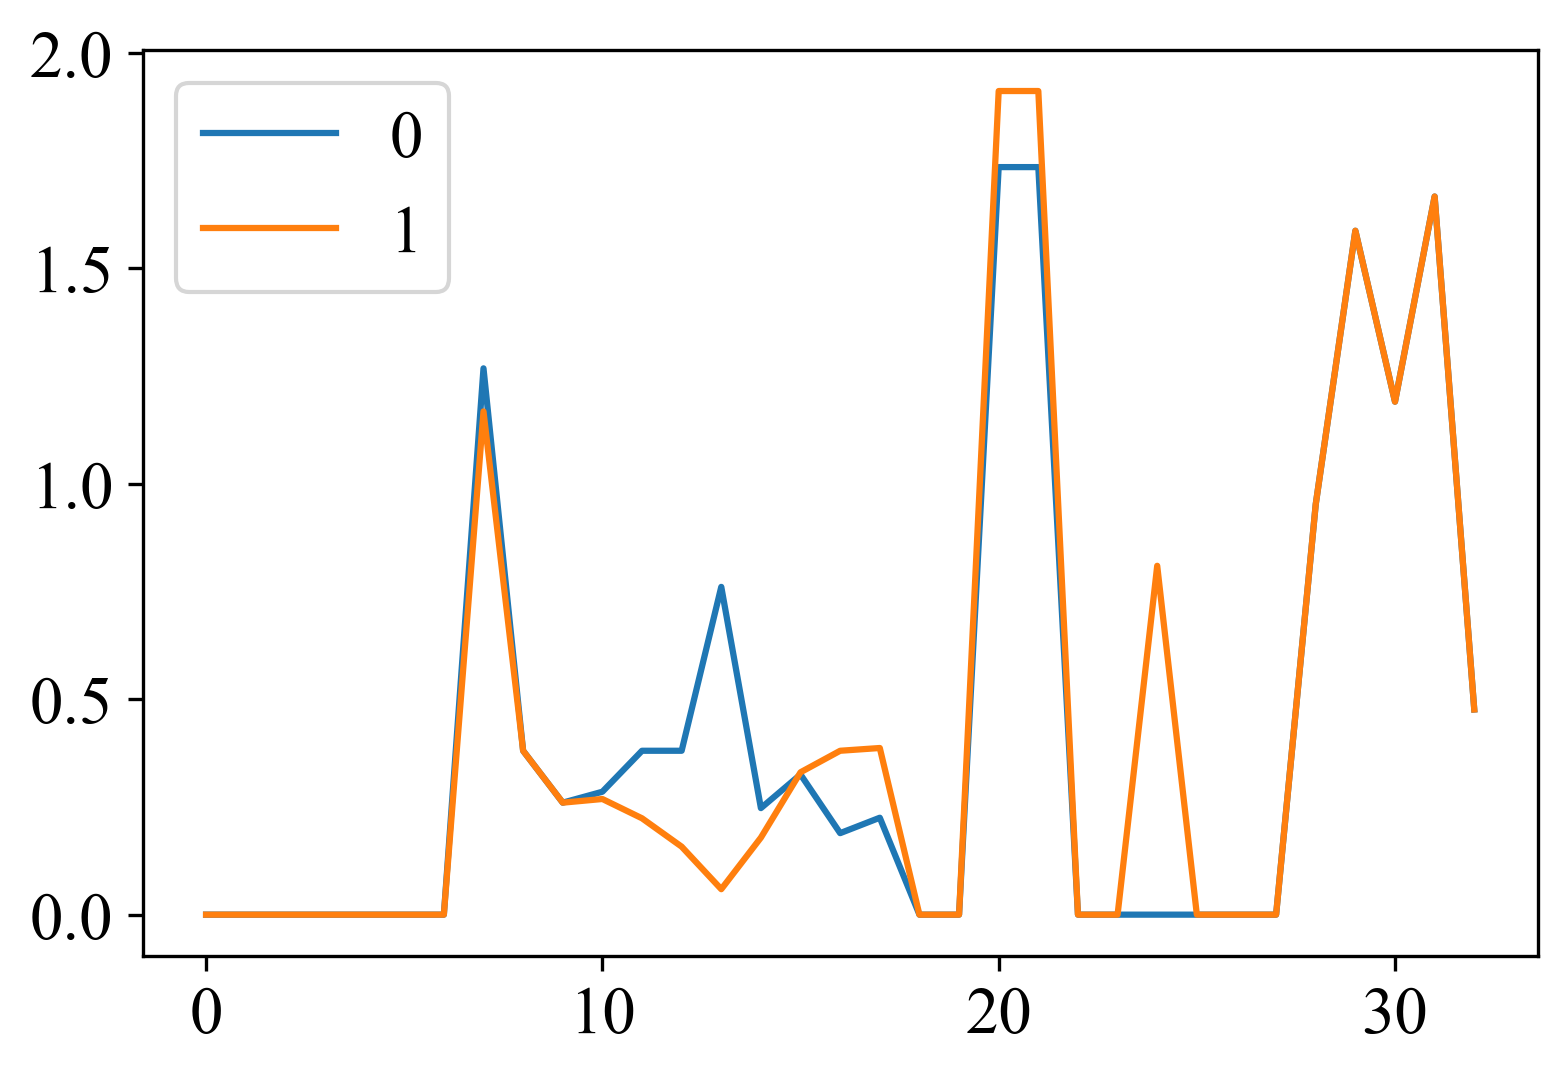

In [12]:
node = list(range(nB))
# for i in range(len(indices)):
#       plt.plot(node, P_bus_shed_set_np[indices[i]], label=str(i))

plt.plot(node, P_bus_shed_set_np[indices[0]], label=str(0))
plt.plot(node, P_bus_shed_set_np[indices[1]], label=str(1))

plt.legend()
plt.show()

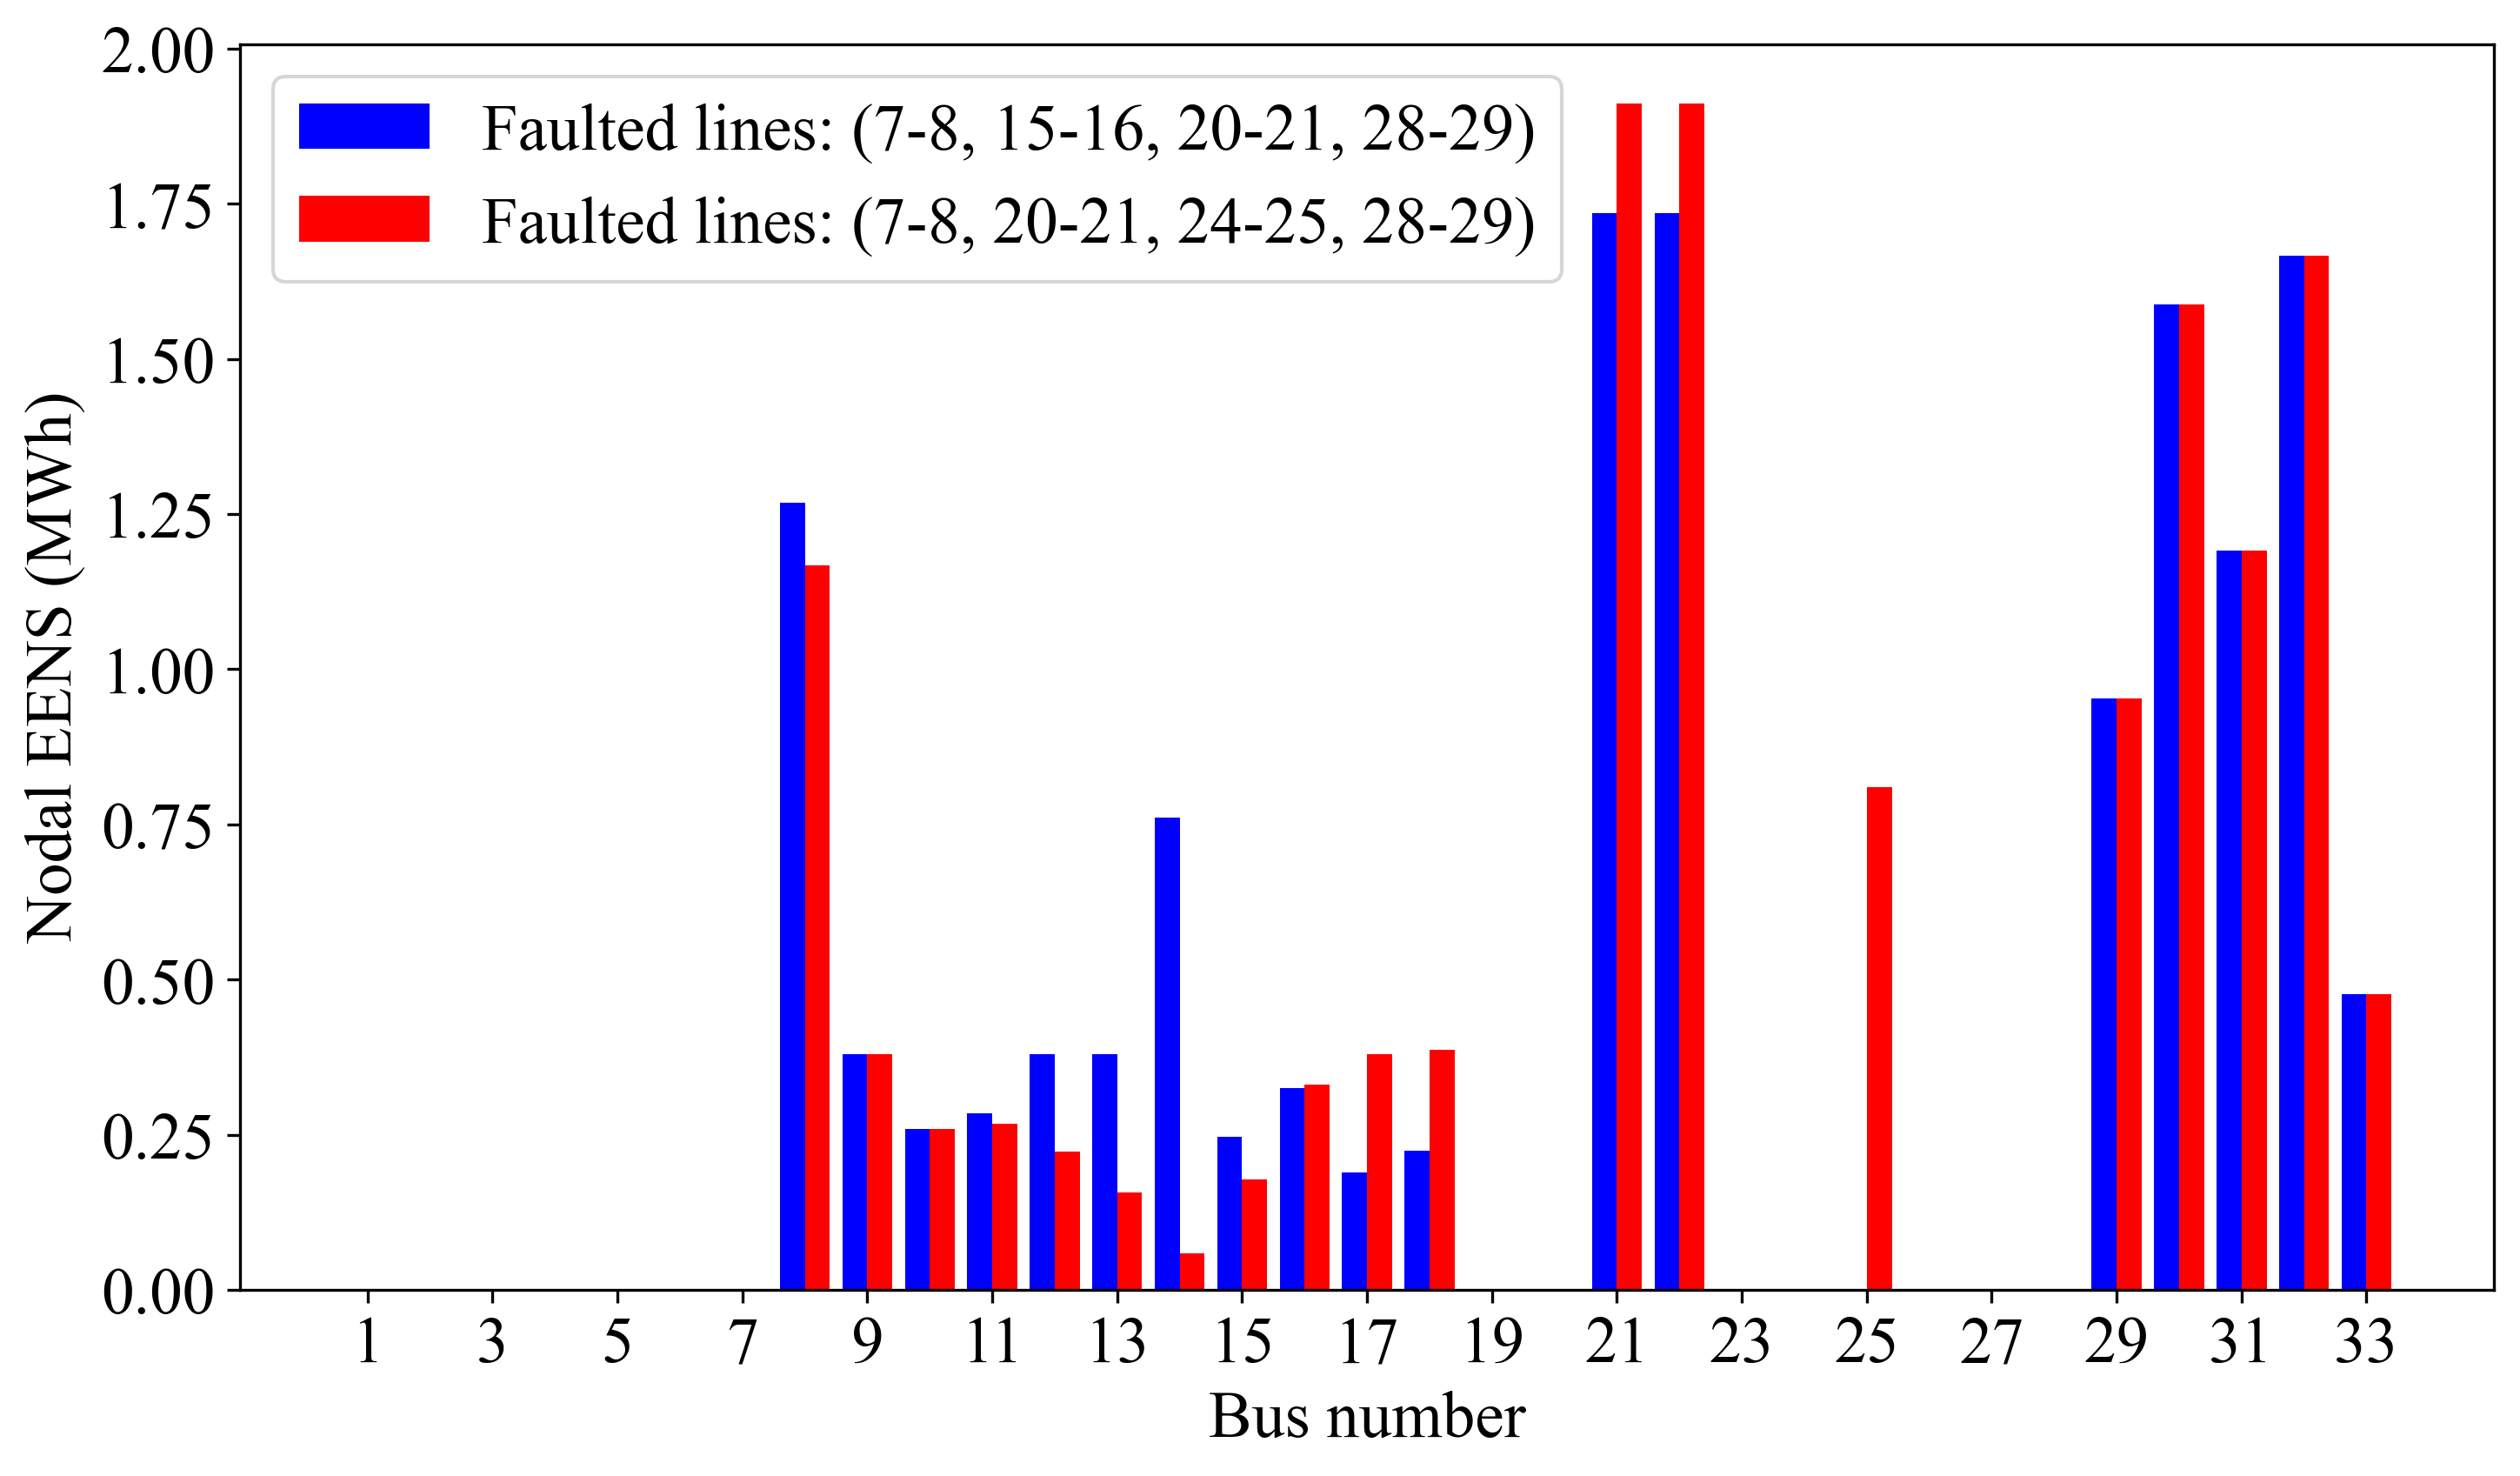

In [13]:
scenario1 = P_bus_shed_set_np[indices[0]]
scenario2 = P_bus_shed_set_np[indices[1]]

# Bar positions
x = np.arange(1, len(node)+1)
width = 0.4  # Width of the bars

# Create a larger figure
plt.figure(figsize=(10, 6))

# Set global font size
plt.rcParams['font.size'] = 18

# Plot the bars
plt.bar(x - width/2, scenario1, width, label='Faulted lines: (7-8, 15-16, 20-21, 28-29)', color='blue')
plt.bar(x + width/2, scenario2, width, label='Faulted lines: (7-8, 20-21, 24-25, 28-29)', color='red')


# Add title, legend, etc.
plt.xlabel('Bus number')
plt.ylabel('Nodal EENS (MWh)')
plt.xticks(x[::2])
plt.legend()

plt.tight_layout()  # Adjust layout for better appearance
plt.show()


In [14]:
# scenarios: fault lines
tripped_lines_candidate = [2, 6, 8, 11, 14, 19, 23, 27, 30]
tripped_lines_set = list(combinations(tripped_lines_candidate, 4))

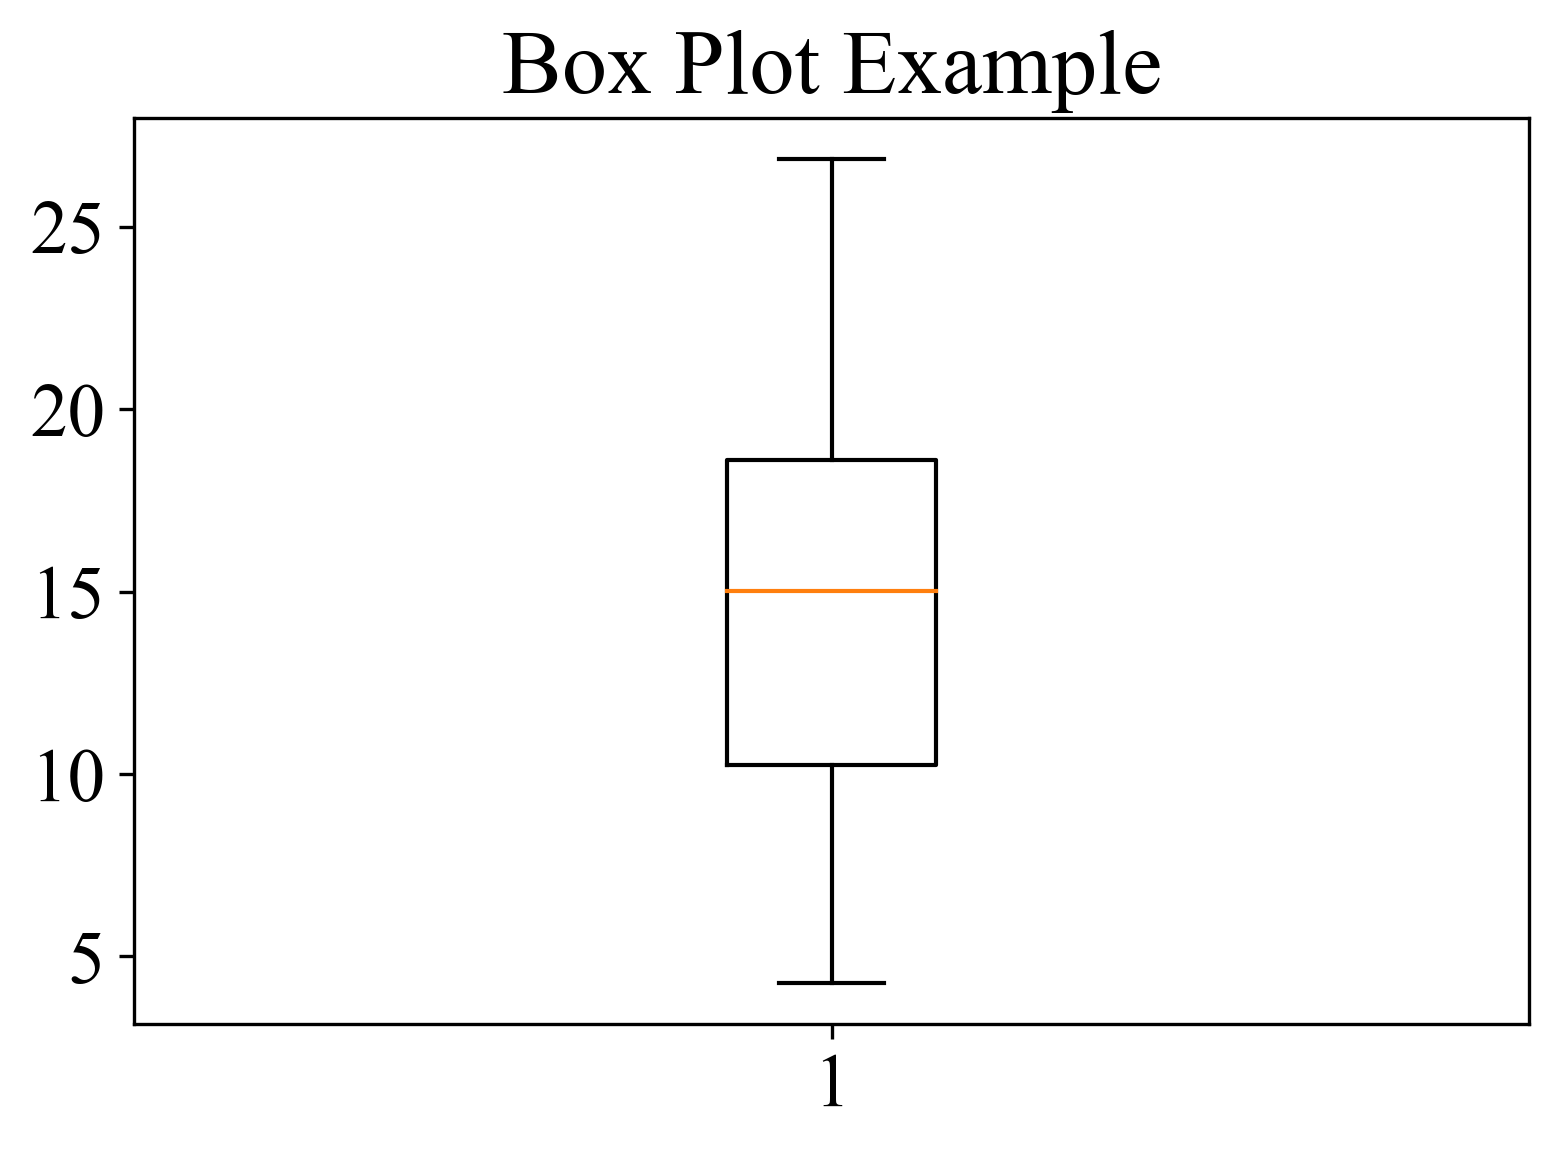

In [18]:
EENS_original

# Create a figure and axis
fig, ax = plt.subplots()

# Create a box plot
ax.boxplot(EENS_original) #, showfliers=True

# Create a box plot
# boxplot = ax.boxplot(EENS_original, showfliers=True)  # Set showfliers=True to show outliers

# Add a title
plt.title('Box Plot Example')

# Show the plot
plt.show()


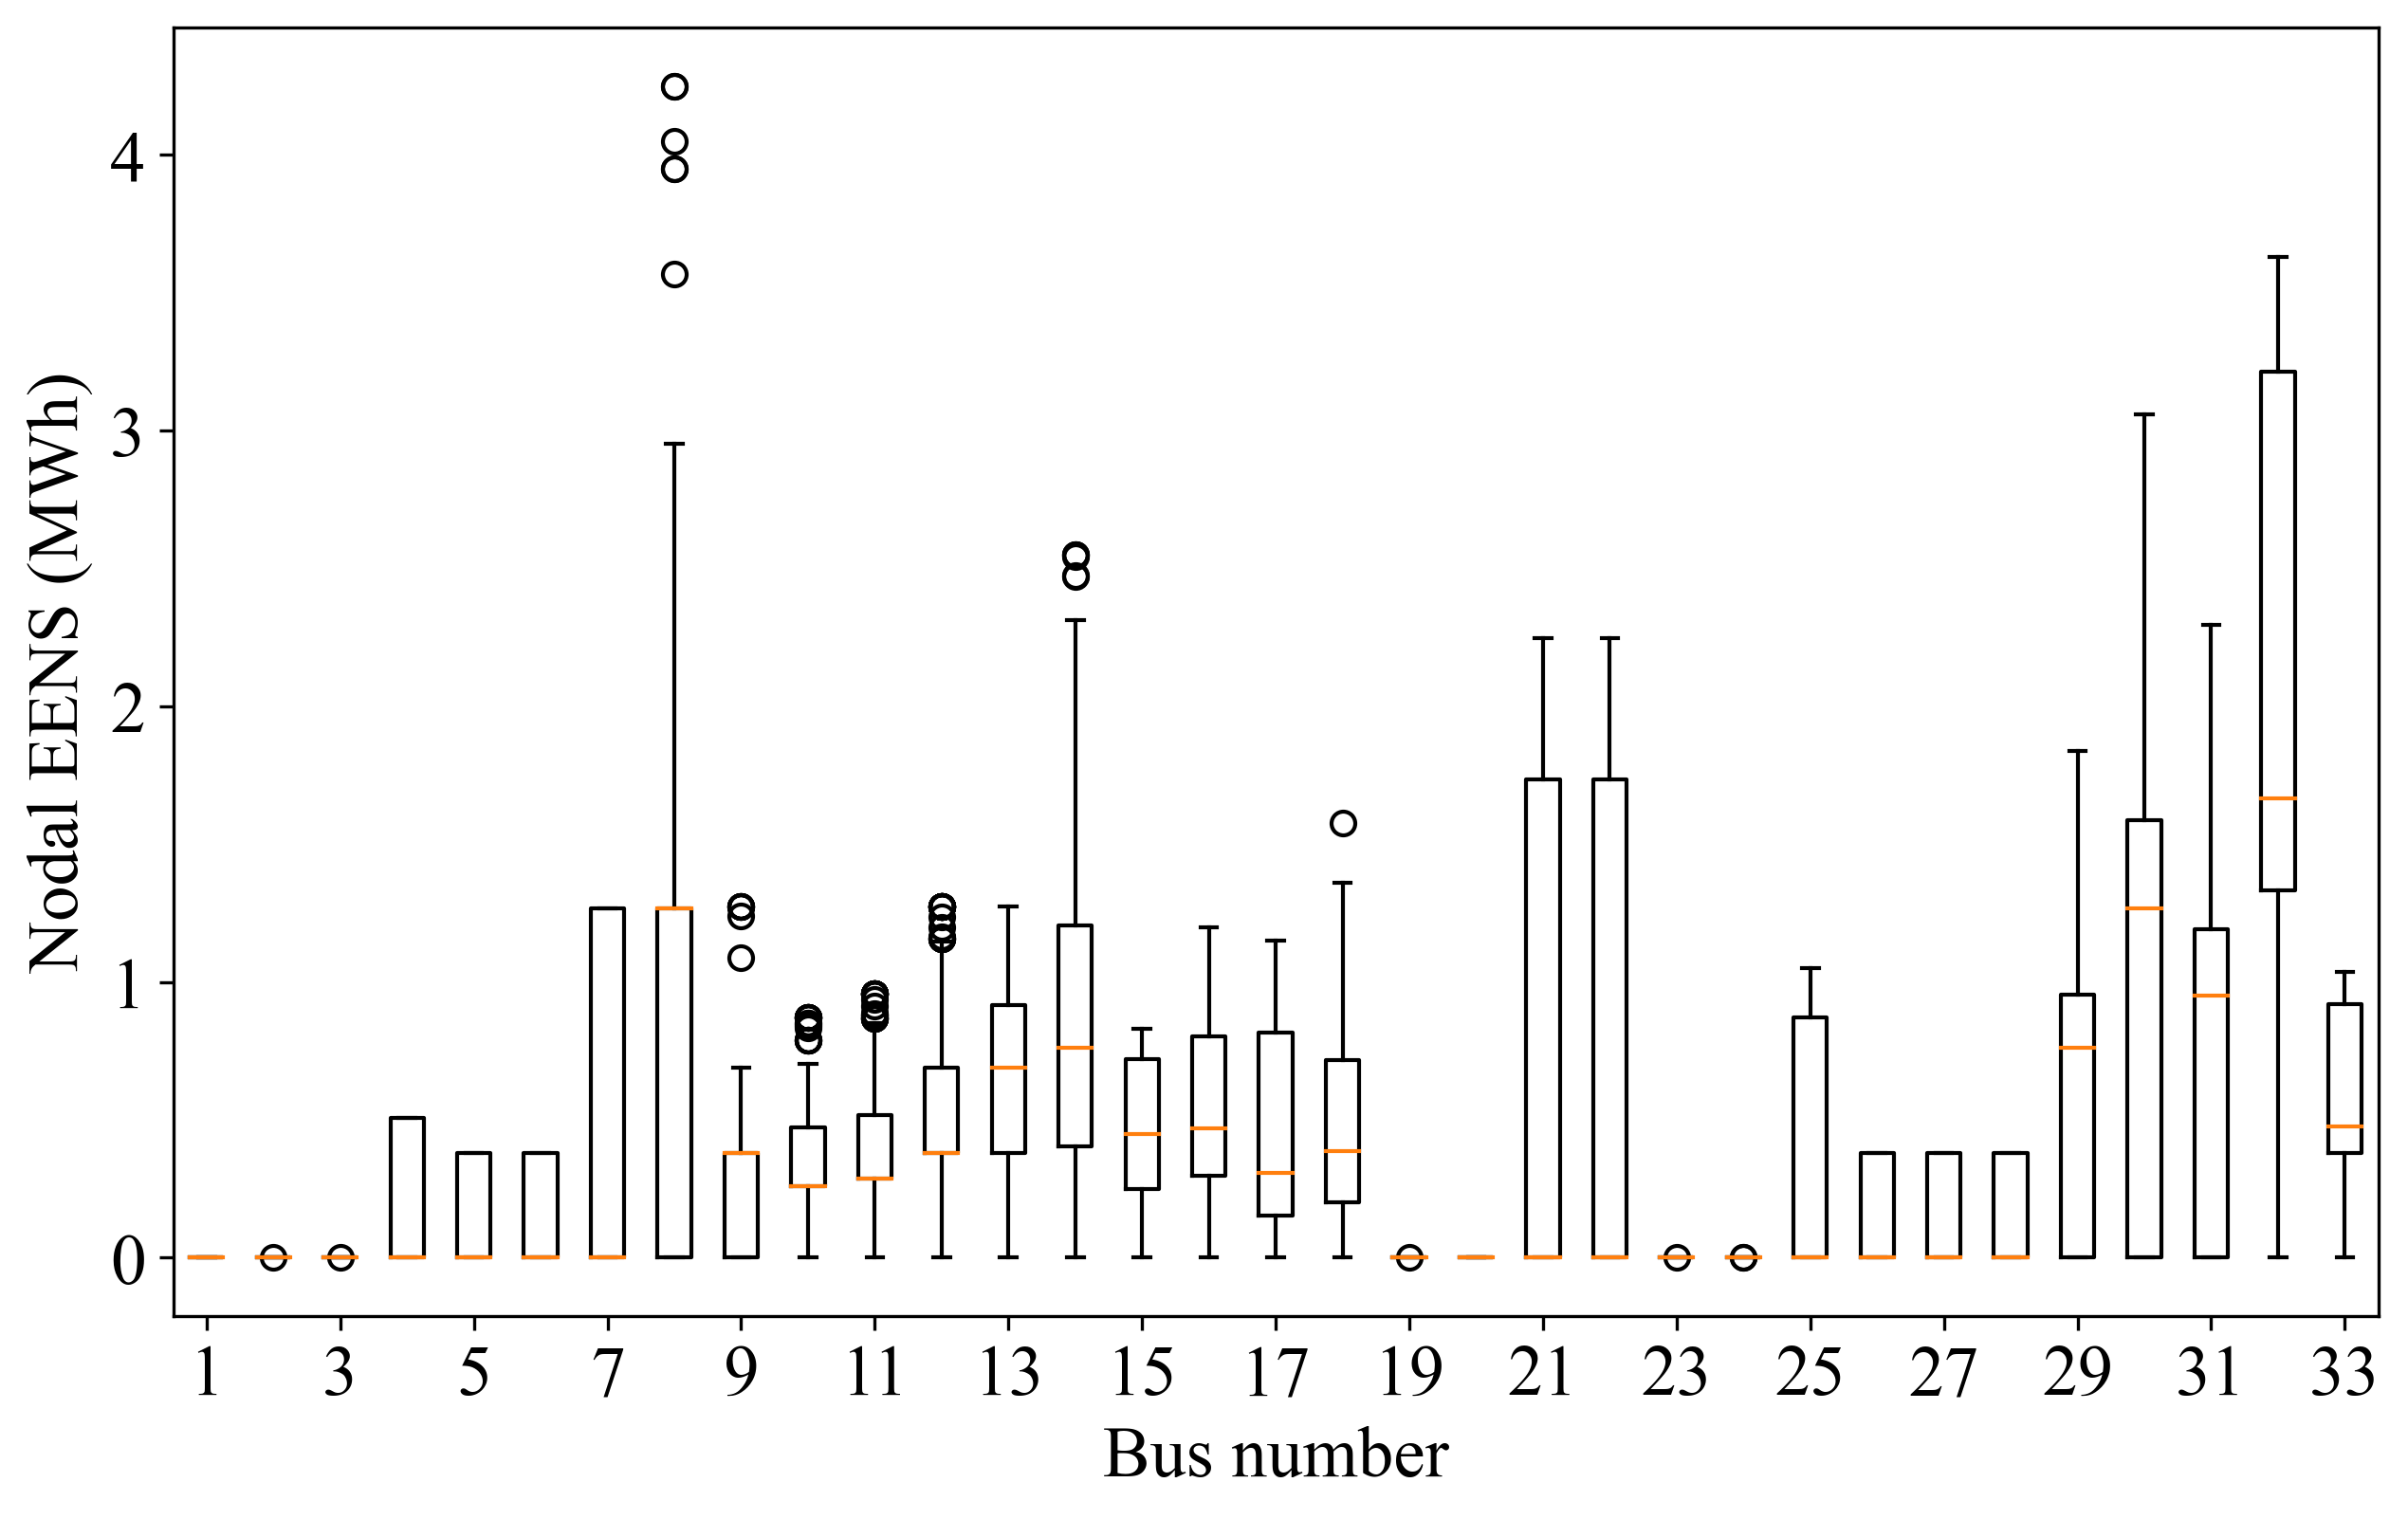

In [19]:
# Create some example data
data = [P_bus_shed_set_np[:,i] for i in range(nB)]

# Set global font size
labels = list(range(1,nB+1))
plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = 18
# Create a figure and axis
# fig, ax = plt.subplots()


# Create a box plot
plt.boxplot(data)

# Add labels to the boxes
# ax.set_xticklabels(['Data 1', 'Data 2', 'Data 3'])

# Add a title
plt.xlabel('Bus number')
plt.ylabel('Nodal EENS (MWh)')
plt.xticks(range(1, len(data) + 1, 2), labels[::2])  # This sets ticks at every 2nd box

# Show the plot
plt.show()


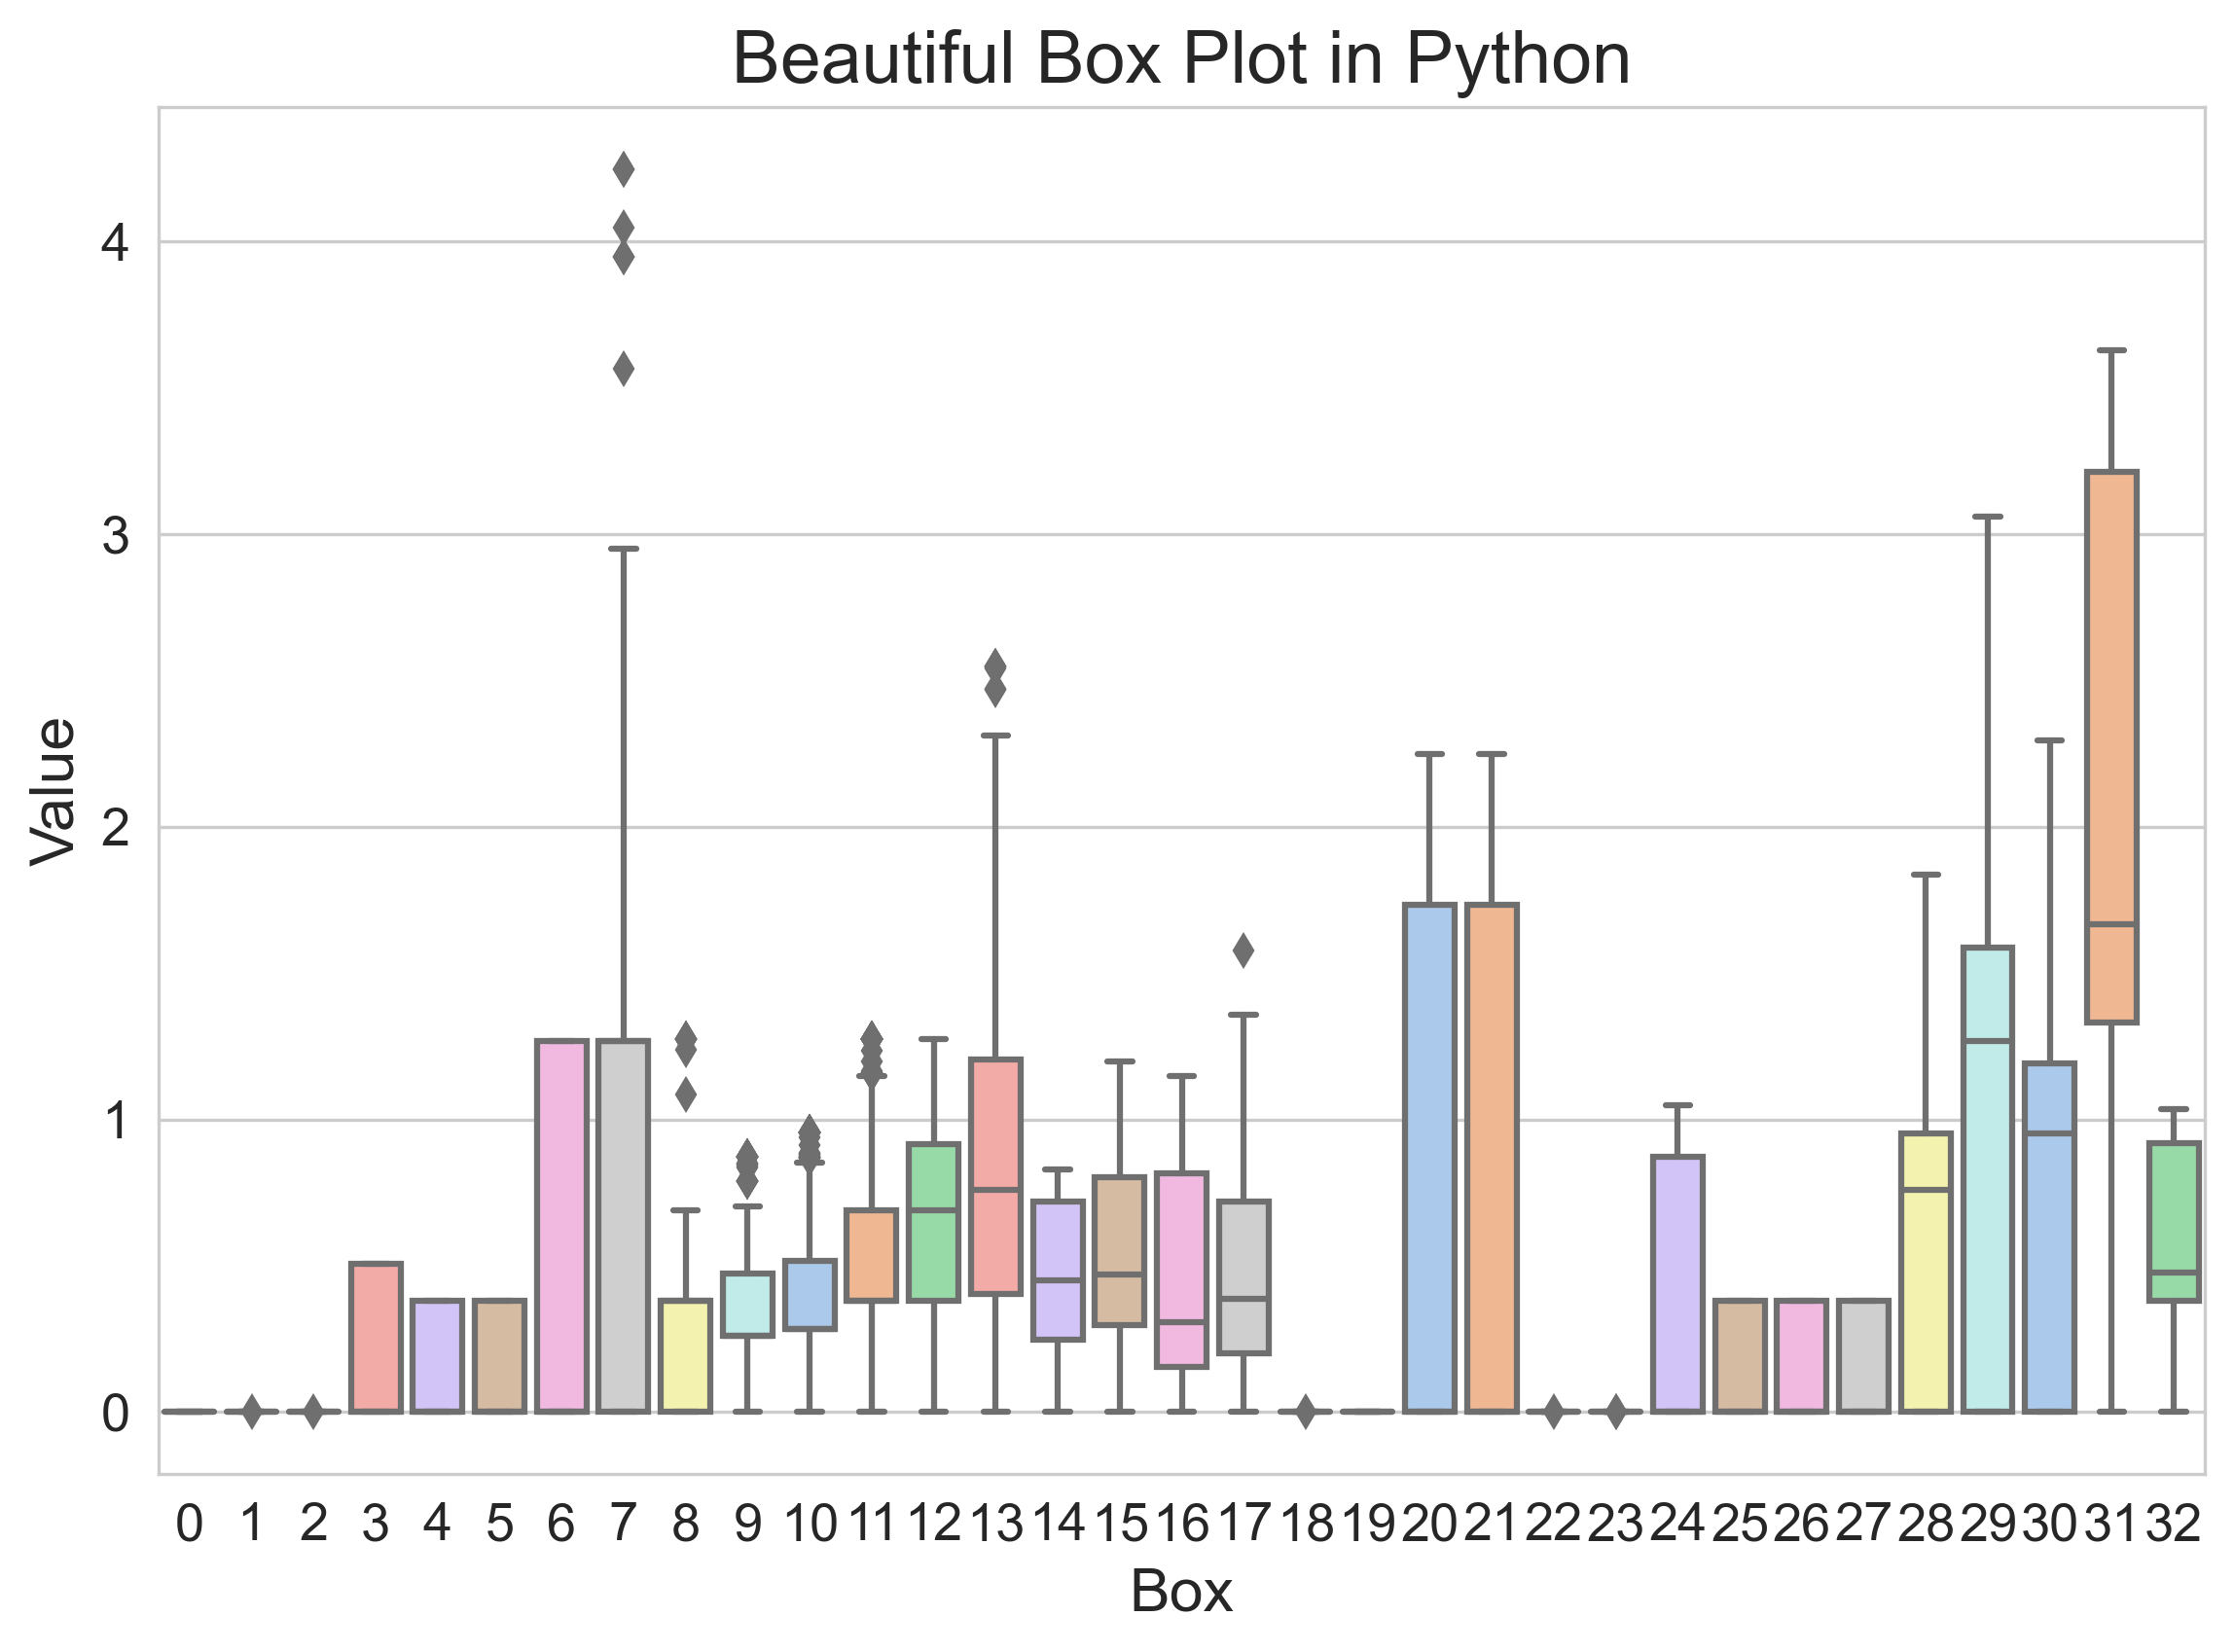

In [20]:
# Set style
sns.set_style('whitegrid')

# Create box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, palette='pastel')

# Customize plot
plt.title('Beautiful Box Plot in Python', fontsize=18)
plt.ylabel('Value', fontsize=15)
plt.xlabel('Box', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Show plot
plt.tight_layout()
plt.show()


In [21]:
k = 25
# Create random centers
unique_random_nums = random.sample(range(0, n_scenario), k)
# Apply k-means clustering
kmeans = KMeans(n_clusters = k, init='k-means++', random_state=42)
kmeans.fit(P_bus_shed_set)
y_kmeans = kmeans.predict(P_bus_shed_set)
centers = kmeans.cluster_centers_

P_bus_shed_set_np = P_bus_shed_set.values


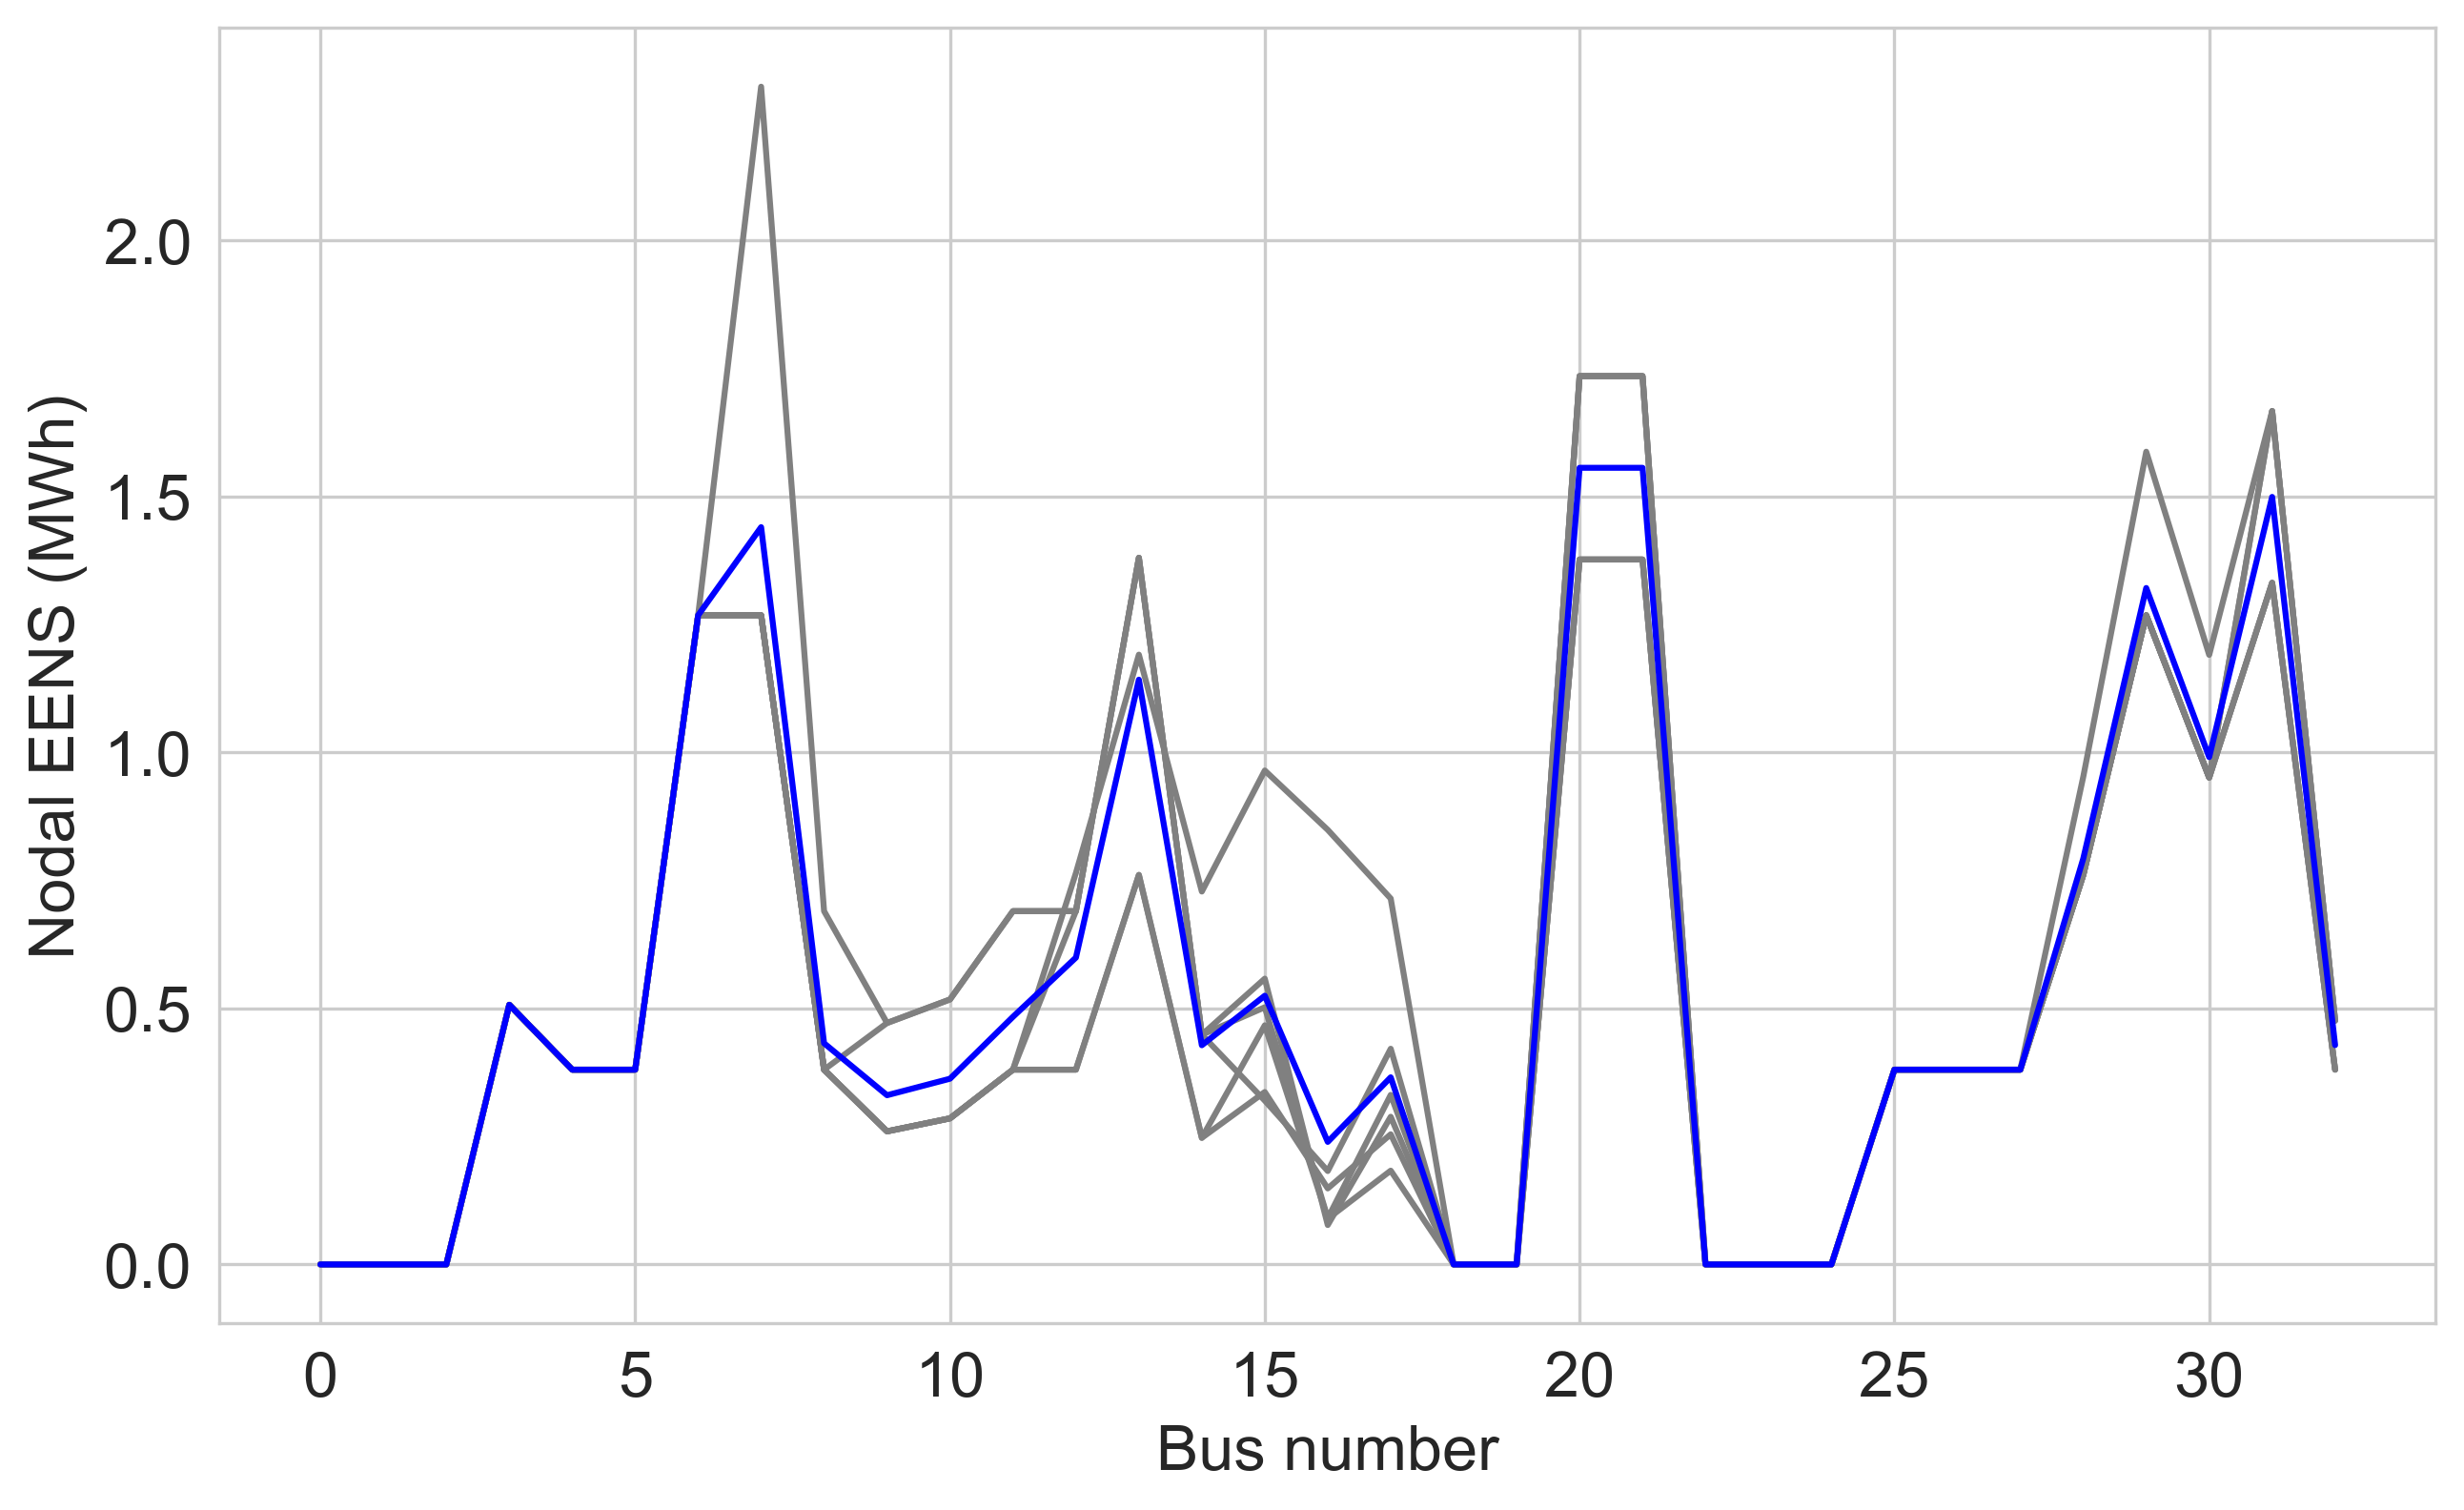

In [22]:
centroid = 4
node = range(nB)
cluster6 = np.where(y_kmeans == centroid)[0]

plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = 16
for i in cluster6:
      plt.plot(node, P_bus_shed_set_np[i], color = 'grey')

plt.plot(node, centers[centroid,:], color = 'blue')
plt.xlabel('Bus number')
plt.ylabel('Nodal EENS (MWh)')
plt.show()      


In [15]:
# Plot nodal unserved load at different node: clustered scenarios
k = 25
# Create random centers
unique_random_nums = random.sample(range(0, n_scenario), k)
# Apply k-means clustering
kmeans = KMeans(n_clusters = k, init='k-means++', random_state=42)
kmeans.fit(P_bus_shed_set)
y_kmeans = kmeans.predict(P_bus_shed_set)
centers = kmeans.cluster_centers_


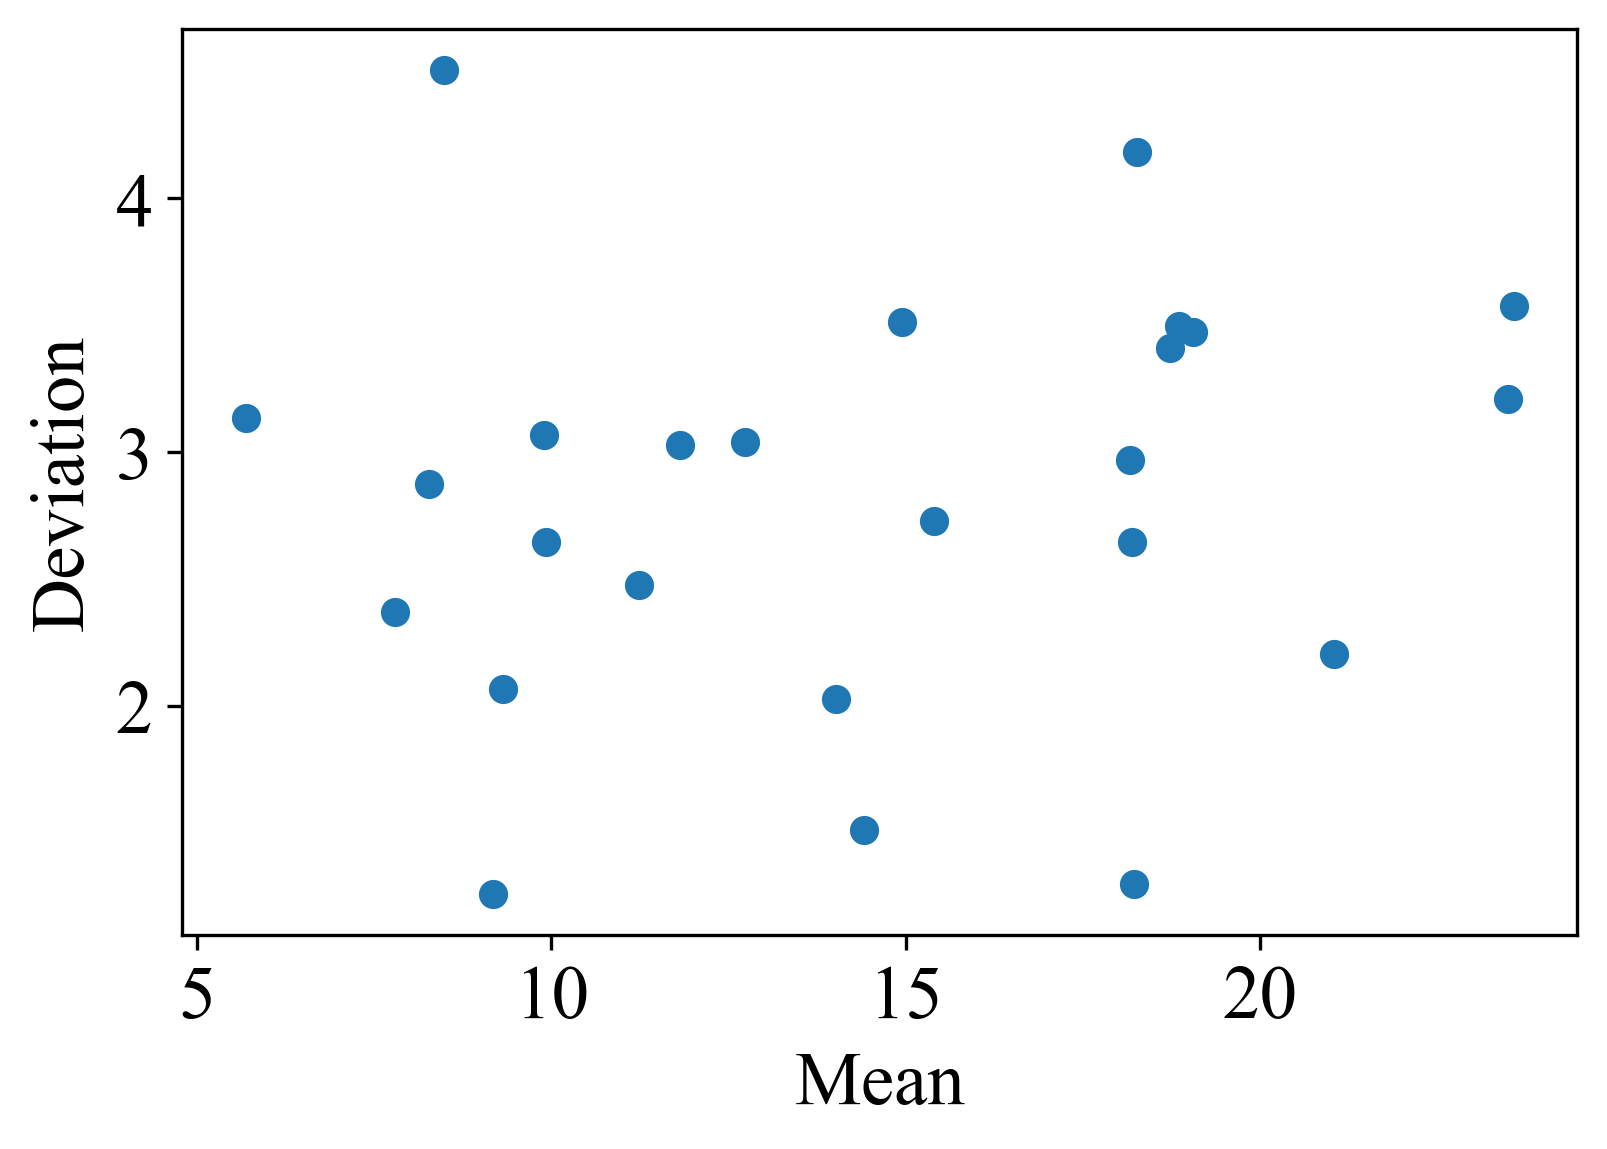

In [16]:
# Plot centroids
mu_simga = np.zeros((k, 2))
P_bus_shed_set_np = P_bus_shed_set.values
for i in range(k):
      indices = np.where(y_kmeans == i)[0]
      mean_vector = np.mean(P_bus_shed_set_np[indices,:], axis=0)
      std_deviation = np.std(P_bus_shed_set_np[indices,:], axis=0)
      mu_simga[i,0] = np.sum(mean_vector)
      mu_simga[i,1] = np.sum(std_deviation)

plt.scatter(mu_simga[:,0], mu_simga[:,1])
plt.xlabel('Mean')
plt.ylabel('Deviation')
plt.show()

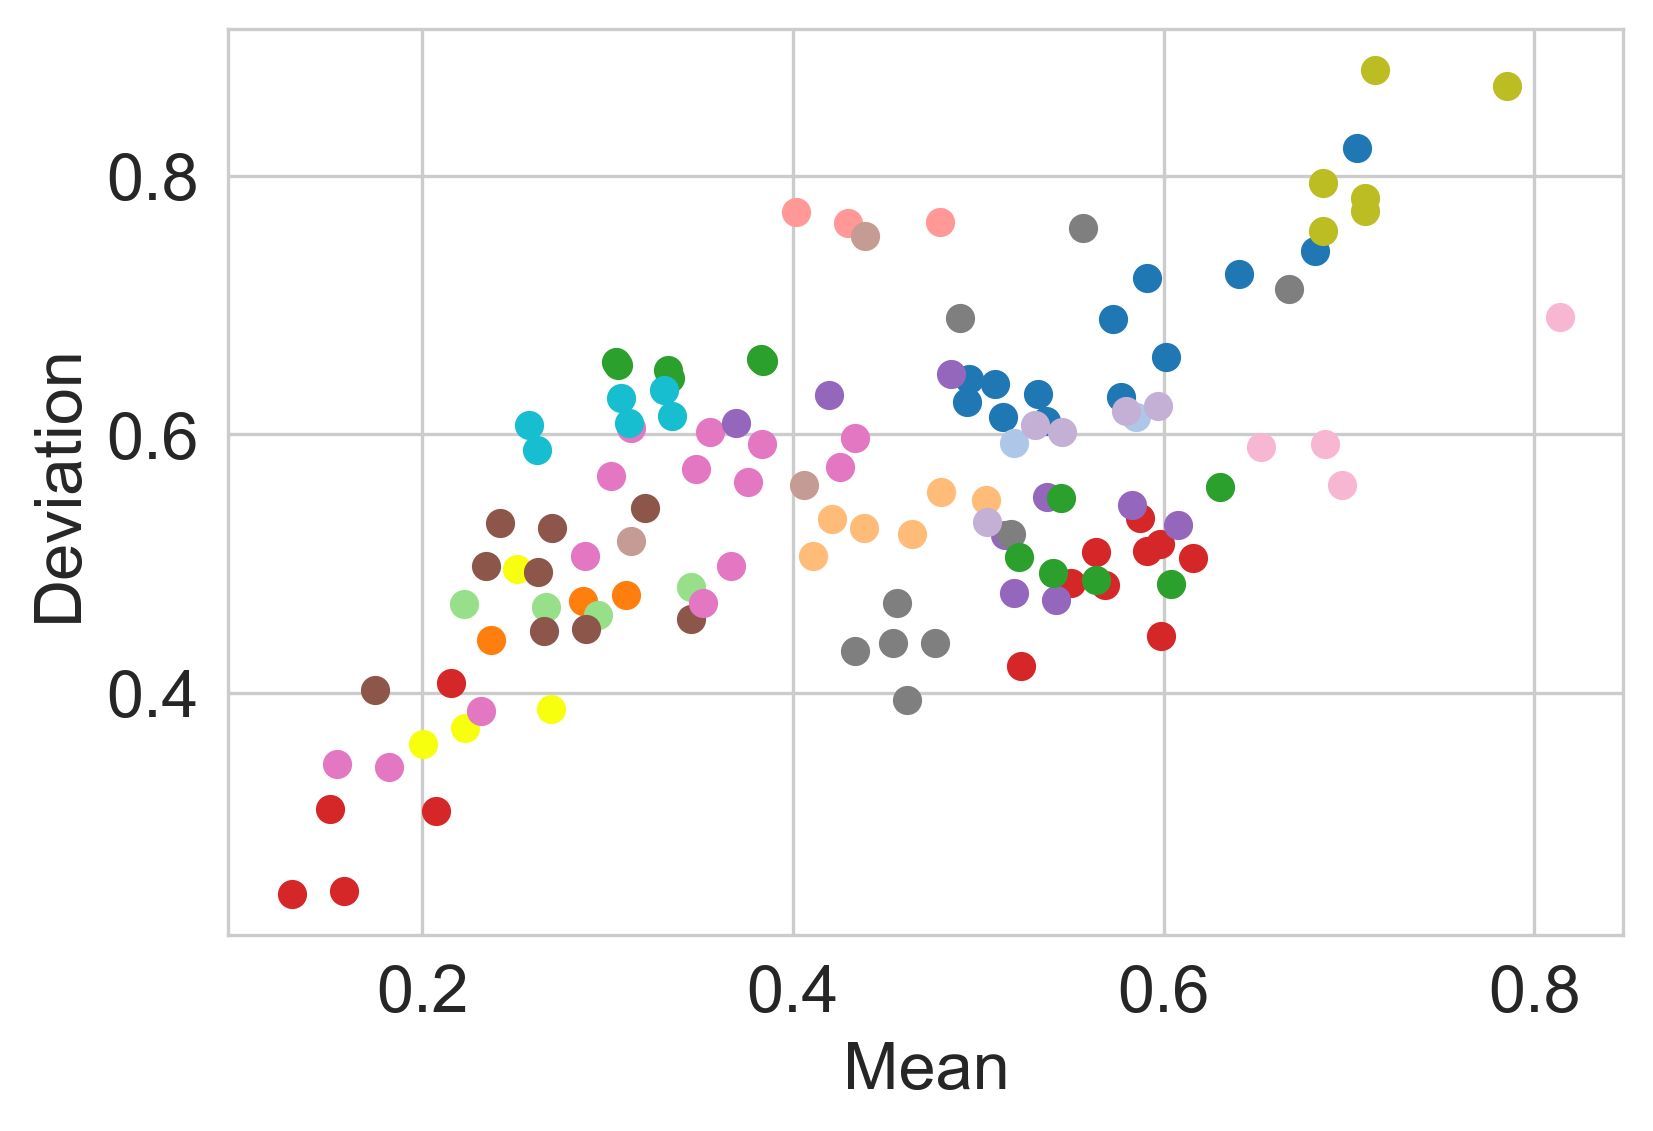

In [25]:
# Plot single scenario
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
tab20_colors = plt.cm.tab20.colors
extended_colors = default_colors + list(tab20_colors)
extended_colors[1] = '#f7ff0e'

mu_simga2 = np.zeros((n_scenario, 2))
P_bus_shed_set_np = P_bus_shed_set.values
for i in range(n_scenario):
      mean_vector = np.mean(P_bus_shed_set_np[i,:], axis=0)
      std_deviation = np.std(P_bus_shed_set_np[i,:], axis=0)
      mu_simga2[i,0] = np.sum(mean_vector)
      mu_simga2[i,1] = np.sum(std_deviation)

for i in range(k):
      indices = np.where(y_kmeans == i)[0]
      plt.scatter(mu_simga2[indices,0], mu_simga2[indices,1], color = extended_colors[i])

plt.xlabel('Mean')
plt.ylabel('Deviation')
plt.show()

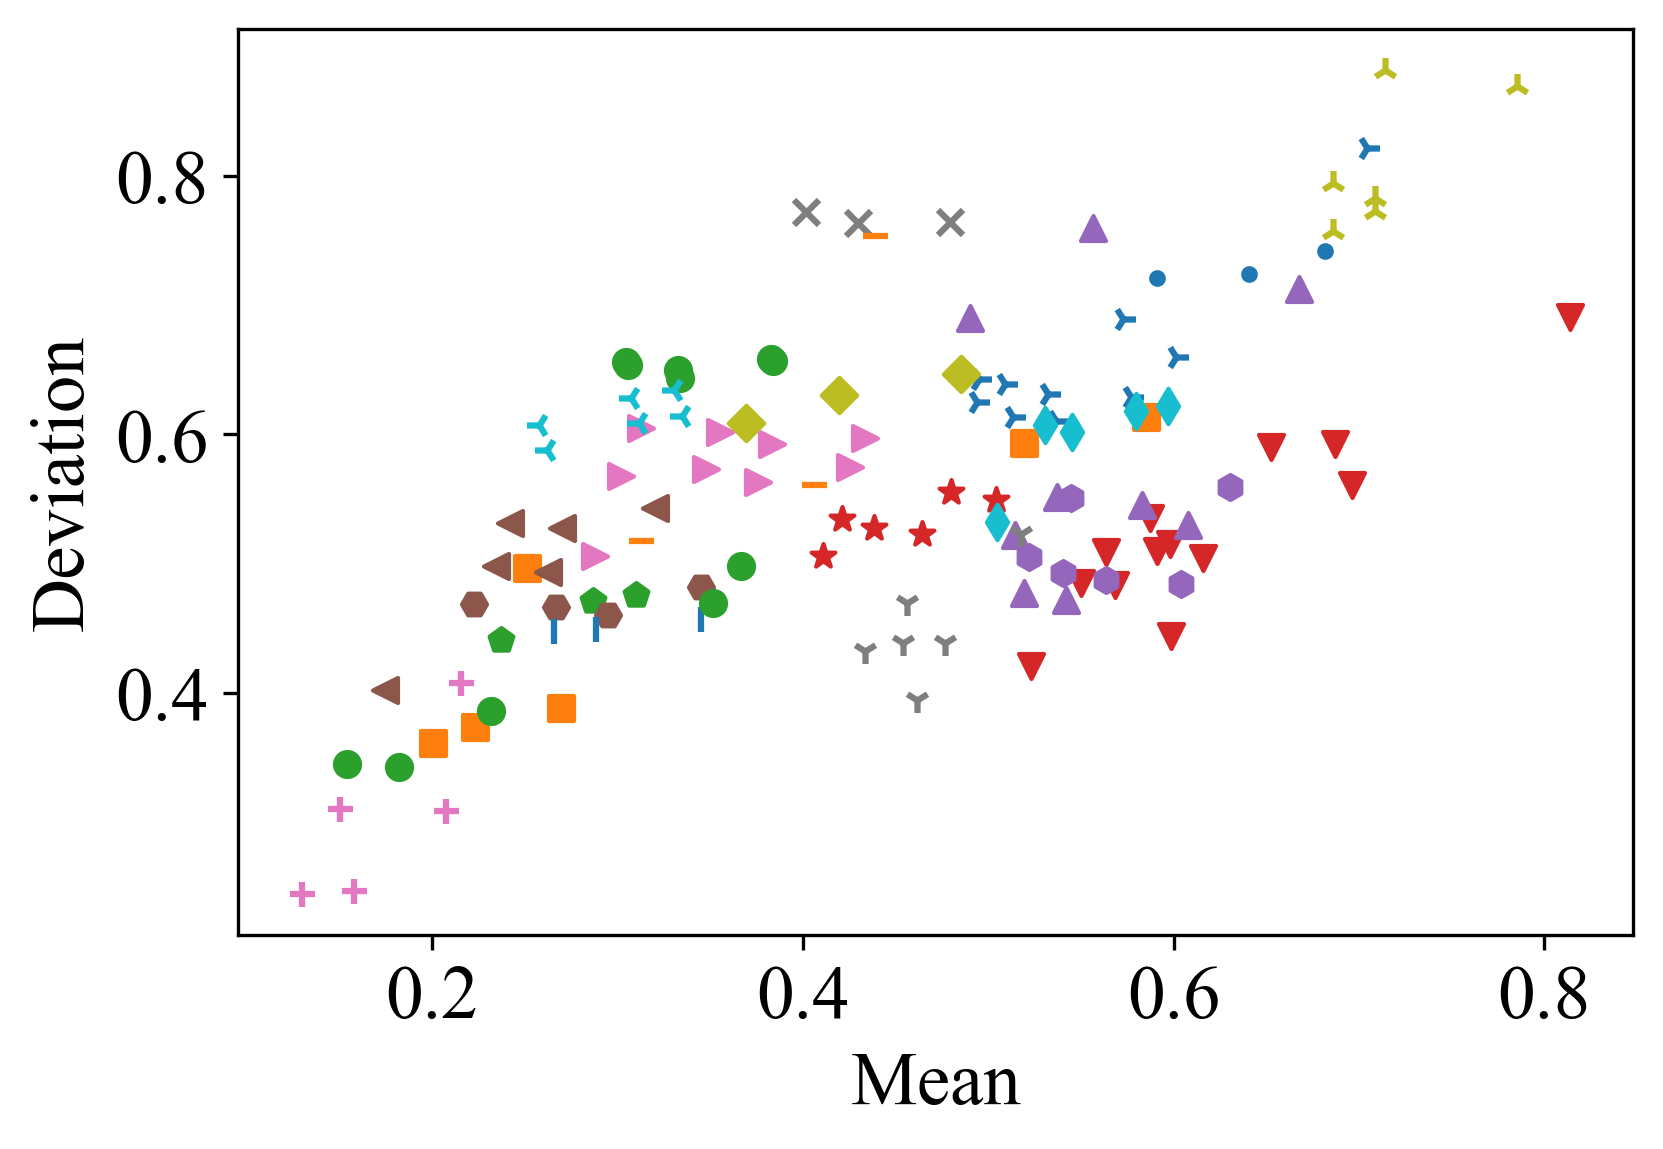

In [17]:
k = 25
# Create random centers
unique_random_nums = random.sample(range(0, n_scenario), k)
# Apply k-means clustering
kmeans = KMeans(n_clusters = k, init='k-means++', random_state=42)
kmeans.fit(P_bus_shed_set)
y_kmeans = kmeans.predict(P_bus_shed_set)
centers = kmeans.cluster_centers_

P_bus_shed_set_np = P_bus_shed_set.values

markers = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', 
           's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
# Extend the list to 25
markers.extend(['o', 'v', '^'])  # Reusing some shapes for demonstration

mu_simga2 = np.zeros((n_scenario, 2))
P_bus_shed_set_np = P_bus_shed_set.values
for i in range(n_scenario):
      mean_vector = np.mean(P_bus_shed_set_np[i,:], axis=0)
      std_deviation = np.std(P_bus_shed_set_np[i,:], axis=0)
      mu_simga2[i,0] = np.sum(mean_vector)
      mu_simga2[i,1] = np.sum(std_deviation)

for i in range(k):
      indices = np.where(y_kmeans == i)[0]
      plt.scatter(mu_simga2[indices,0], mu_simga2[indices,1], marker = markers[i])

plt.xlabel('Mean')
plt.ylabel('Deviation')
plt.show()

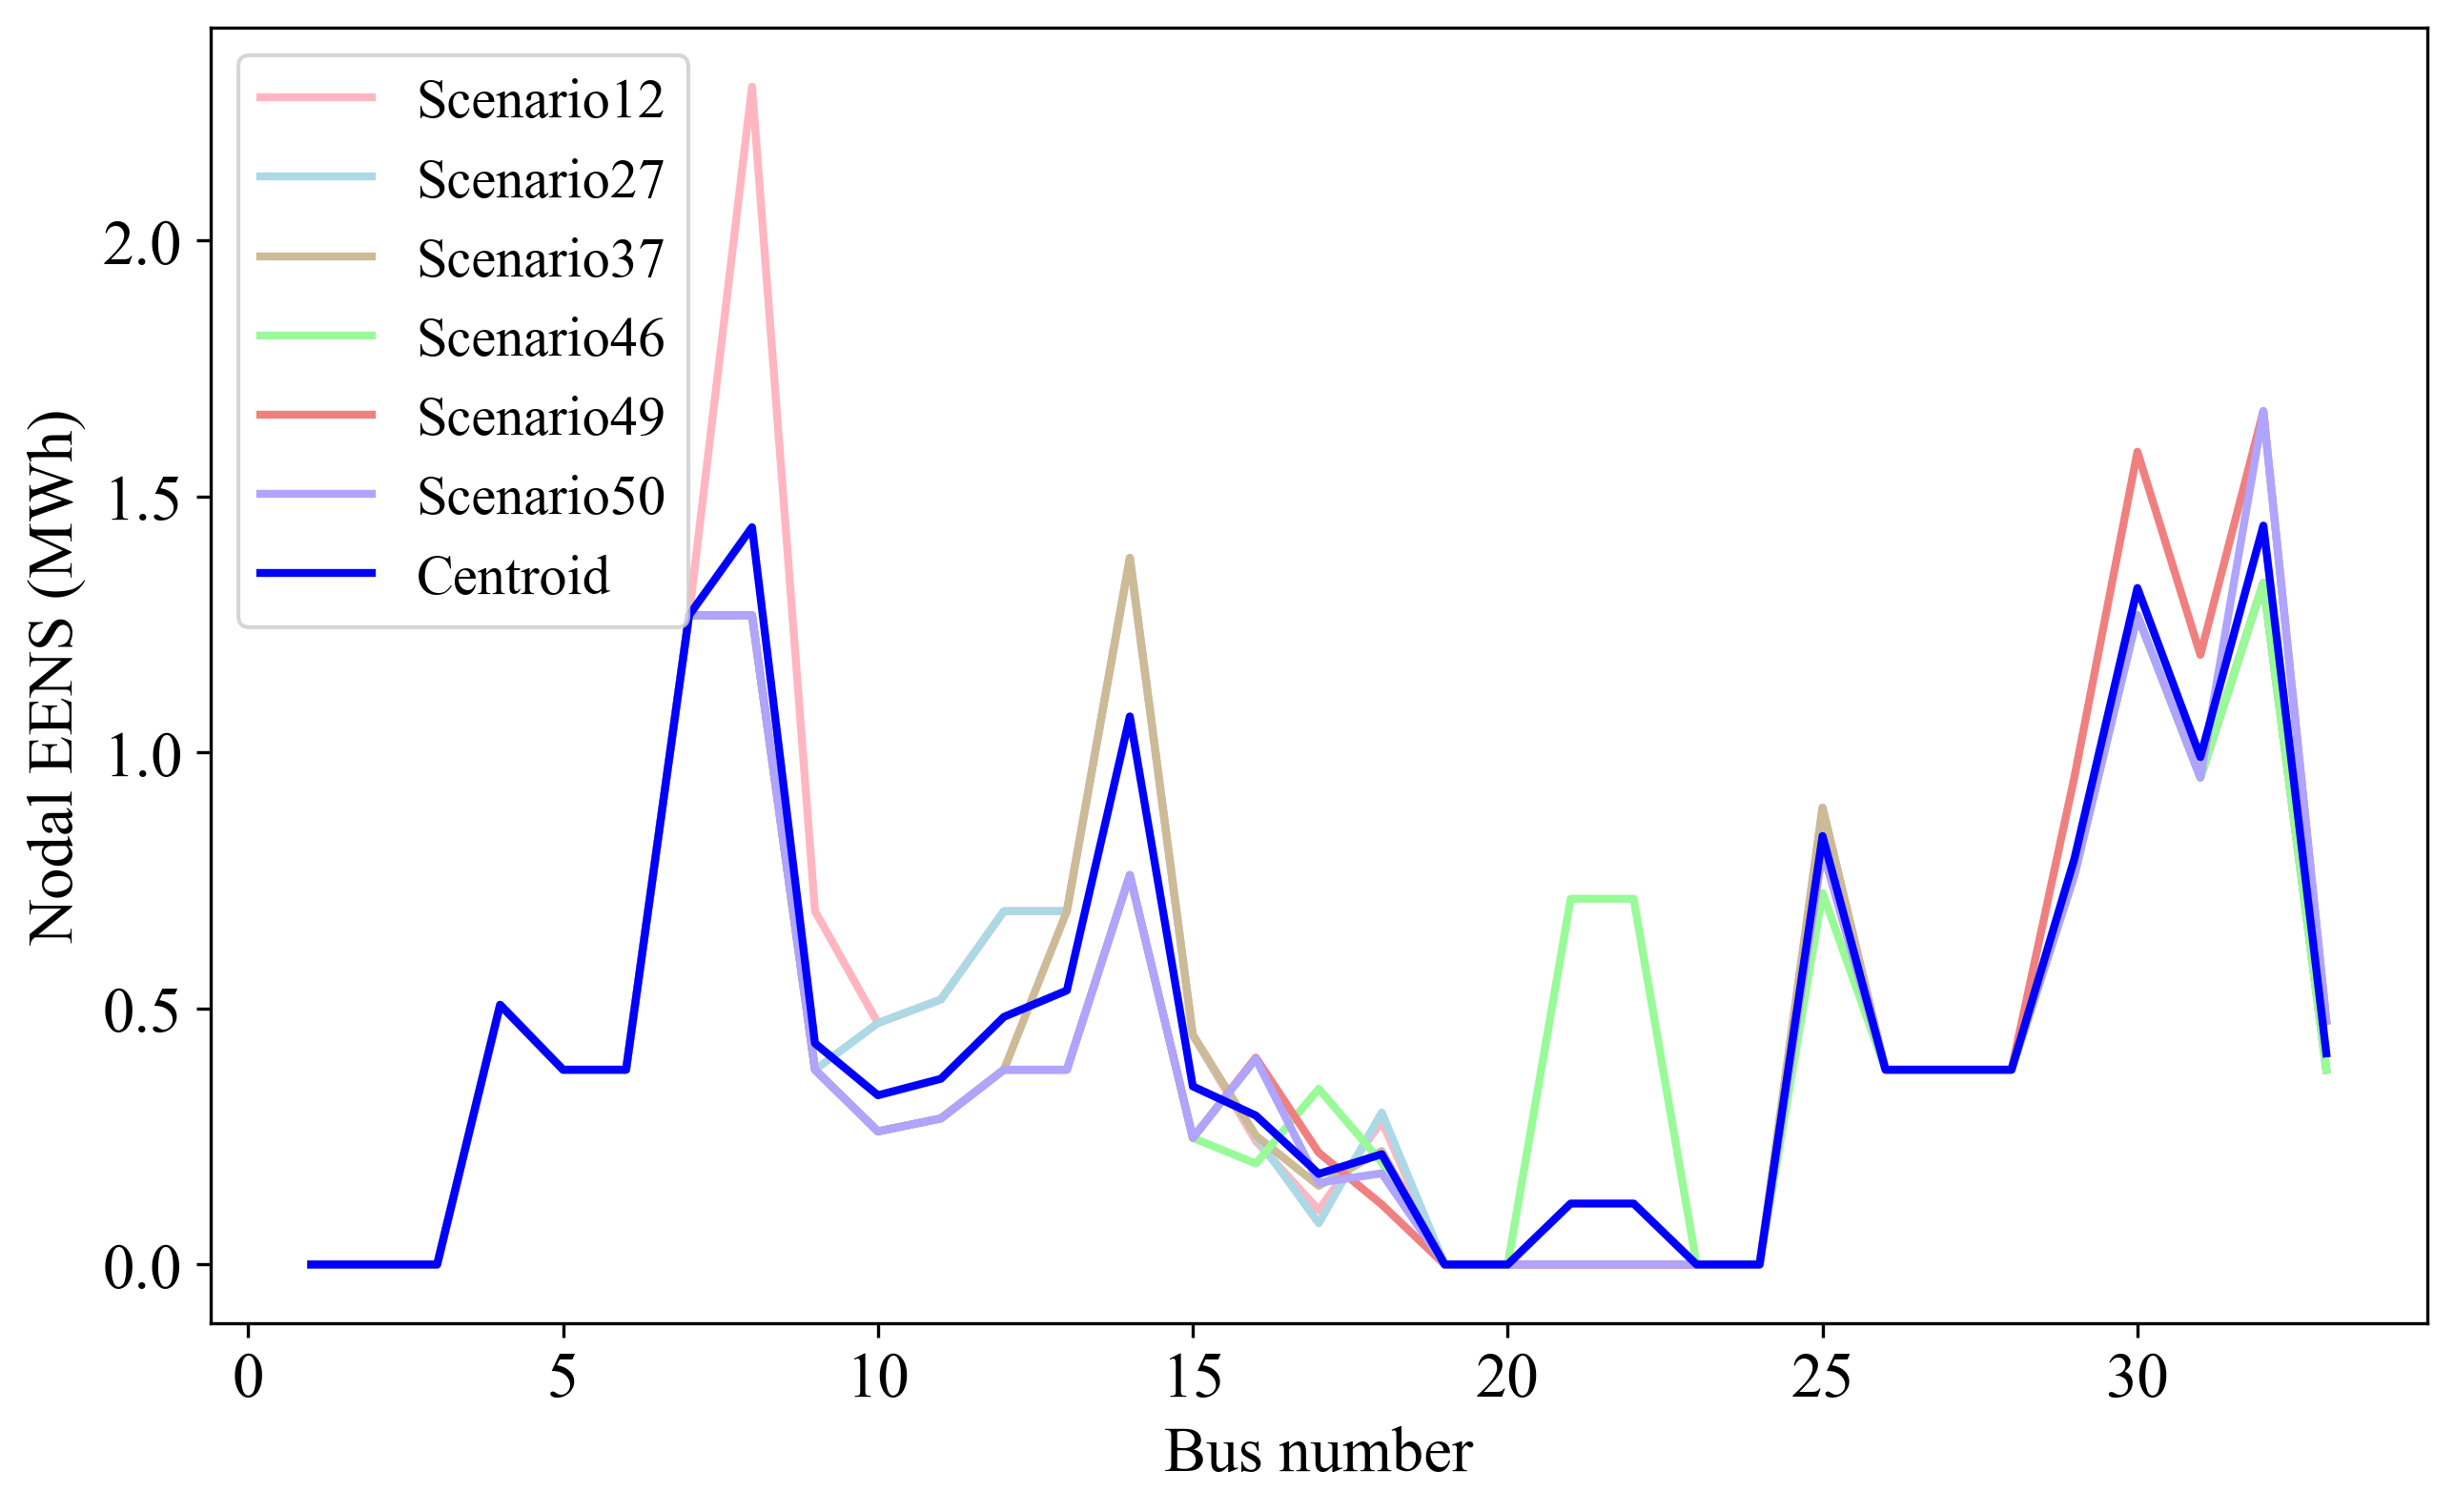

In [19]:
plt.rcParams['font.family'] = 'Times New Roman'
# centroid = 7
centroid = 7
node = range(1, nB+1)
cluster6 = np.where(y_kmeans == centroid)[0]
j = 0
colors = ['#FFB6C1', '#ADD8E6', '#CDBA96', '#98FB98', '#F08080', '#AFA4FF'] #  #E6E6FA

plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = 16
for i in cluster6:
      plt.plot(node, P_bus_shed_set_np[i], color = colors[j], label = 'Scenario' + str(i), linewidth = 2)
      j = j + 1

plt.plot(node, centers[centroid,:], color = 'blue', label = 'Centroid', linewidth = 2)
plt.xlabel('Bus number')
plt.ylabel('Nodal EENS (MWh)')
# plt.grid(False)
plt.legend(loc='upper left', fontsize = 14)
plt.show()    